In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pylab as pl
from scipy import stats
import scipy.stats as st
import statsmodels as sm
from statsmodels import regression
import random
import matplotlib.patches as mpatches
from scipy import optimize
from scipy.cluster.hierarchy import linkage
from matplotlib import pyplot as plt
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial import KDTree
from scipy.spatial import distance
from scipy.special import gamma
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from sklearn.mixture import GMM
from sklearn.metrics import mean_squared_error
from sklearn import svm



%matplotlib inline

In [3]:
data = np.genfromtxt("sdss_quasar.txt", skip_header=1)

#     fig = plt.figure(figsize = (10, 10))
#     ax = fig.gca(projection='3d')

In [4]:
redshift = data[:,3]

u = data[:,4]
u_err = data[:,5]

g = data[:,6]
g_err = data[:,7]

r = data[:,8]
r_err = data[:,9]

i = data[:,10]
i_err = data[:,11]

z = data[:,12]
z_err = data[:,13]

xray = data[:,15]

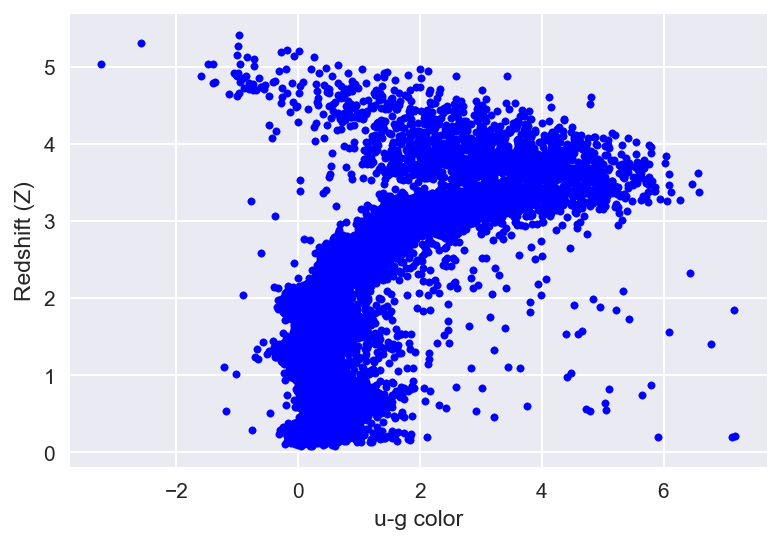

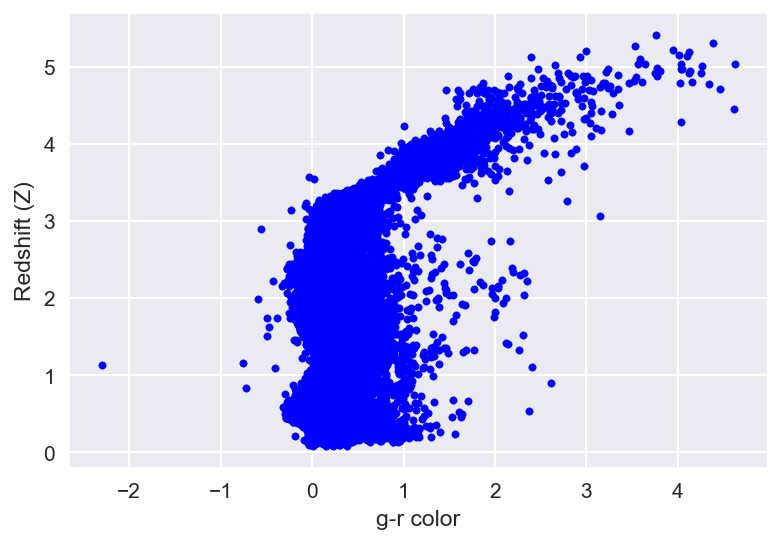

In [9]:
plt.figure(dpi=150)
plt.scatter(ug,redshift, color='blue', marker='.')
plt.xlabel('u-g color')
plt.ylabel('Redshift (Z)')
plt.savefig('ug redplot')
plt.figure(dpi=150)
plt.scatter(gr, redshift, color='blue', marker='.')
plt.xlabel('g-r color')
plt.ylabel('Redshift (Z)')
plt.savefig('gr redplot')

# Regression

In [5]:
ug = np.subtract(u,g)
gr = np.subtract(g,r)
ri = np.subtract(r,i)
iz = np.subtract(i,z)


In [39]:
# error propagation

def get_error(error1,error2):
    err_vals = []
    for i in range(len(error1)): 
        result_err = np.sqrt((error1[i]**2)+(error2[i]**2))
        err_vals.append(result_err)
    return np.array(err_vals)

# define a function for getting regression model

def poly_regress(x,y,d):
    poly = PolynomialRegression(d)
    poly.fit(x[:, None], y)
    y_fit = poly.predict(x[:, None])
    return y_fit

# want to sort list 
def sort(x):
    inds = x.argsort()
    sorted_values = x[inds]
    return sorted_values, inds

ug_err = get_error(u_err,g_err)
gr_err = get_error(g_err,r_err)
ri_err = get_error(r_err,i_err)
iz_err = get_error(i_err,z_err)

In [40]:
def get_residuals(y,ymodel):
    resid = []
    for i in range(len(y)):
        res = y[i] - ymodel[i]
        resid.append(res)
    resid = np.array(resid)
    return resid

def get_chi2(y,ymodel,k):
    #where k is our degrees of freedom, or (i)
    resid = get_residuals(y,ymodel)
    chi2 = np.sum(((resid)**2)/(np.var(y)**2))
    return  chi2

def get_aic(k,y,ymodel):
    chi2 = get_chi2(y,ymodel,k)
    N = len(y)
    aic =(chi2 + (2*k) + (2*k*(k+1)/(N-k-1)))
    return aic

def get_bic(k,y,ymodel):
    chi2 = get_chi2(y,ymodel,k)
    N = len(y)
    bic = (chi2 + (k*(np.log(N))))
    return bic

def get_adj_r2(k,y,ymodel):
    r2 = sklearn.metrics.r2_score(y,ymodel)
    N = len(y)
    ad_r2 = r2-(((k-1)/(N-k))*(1-r2))
    return ad_r2

def get_rms(y_actual,y_predict):
    rms = np.sqrt(mean_squared_error(y_actual, y_predict))
    return rms

# u-g

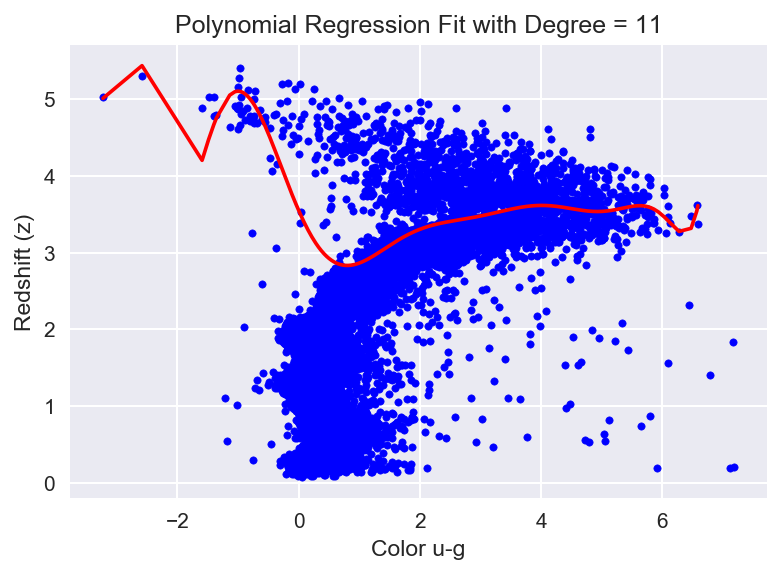

In [201]:
from astroML.linear_model import LinearRegression, PolynomialRegression
from mpl_toolkits.mplot3d import Axes3D

# sort redshift by the ug values in ascending order (do this for every color)so that regression works

sorted_ug = sort(ug)[0]
red_ug = redshift[sort(ug)[1]]

# create mask for redshift above 2.5
zm = (red_ug > 2.5)
red_ug = red_ug[zm]
sorted_ug = sorted_ug[zm]

degrees = [11]
for d in degrees:
    x = sorted_ug
    y = red_ug
    y_fit = poly_regress(x, y,d)


    plt.figure(dpi=150)
    plt.plot(sorted_ug, y_fit, color='red')
    plt.scatter(ug,redshift, color='blue', marker='.')
    plt.ylabel("Redshift (z)")
    plt.xlabel("Color u-g")
    plt.title("Polynomial Regression Fit with Degree = %.f" %d)
    plt.savefig('u-g FIT')
    plt.show()

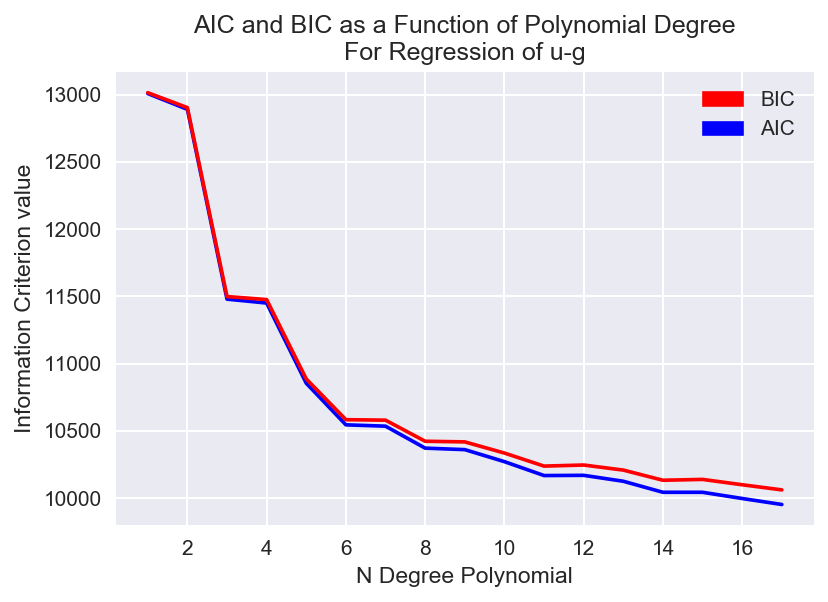

In [202]:
aic = []
bic = []
degrees = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

for d in degrees:
    x = sorted_ug
    y = red_ug
    y_fit = poly_regress(x, y, d)
    error = np.std(y)

    get_chi2(y,y_fit,d)
    aic.append(get_aic(d,y,y_fit))
    bic.append(get_bic(d,y,y_fit))

x_range = np.arange(1,18)

plt.figure(dpi=150)
plt.plot(x_range, aic, color='blue')
plt.plot(x_range, bic, color='red')

blue_patch = mpatches.Patch(color='blue', label='AIC')
red_patch = mpatches.Patch(color='red', label='BIC')

plt.legend(handles=[red_patch, blue_patch])
plt.title("AIC and BIC as a Function of Polynomial Degree\nFor Regression of u-g")

plt.ylabel('Information Criterion value')
plt.xlabel('N Degree Polynomial')
plt.savefig('u-g AIC  BIC')
plt.show()

http://proquest.safaribooksonline.com/book/programming/python/9780691151687/8-regression-and-model-fitting/82_regression_for_linear_model?reader=pf&readerfullscreen=&readerleftmenu=1#X2ludGVybmFsX1BGVmlldz94bWxpZD05NzgwNjkxMTUxNjg3JTJGMzI4Jl9faW1hZ2VwYWdlcmVzb2x1dGlvbj04MDAmcXVlcnk9

In [43]:
# split up data into training and cross validation sets for ug

x_train, x_cv, y_train, y_cv = train_test_split(sorted_ug,red_ug,test_size= 0.2)


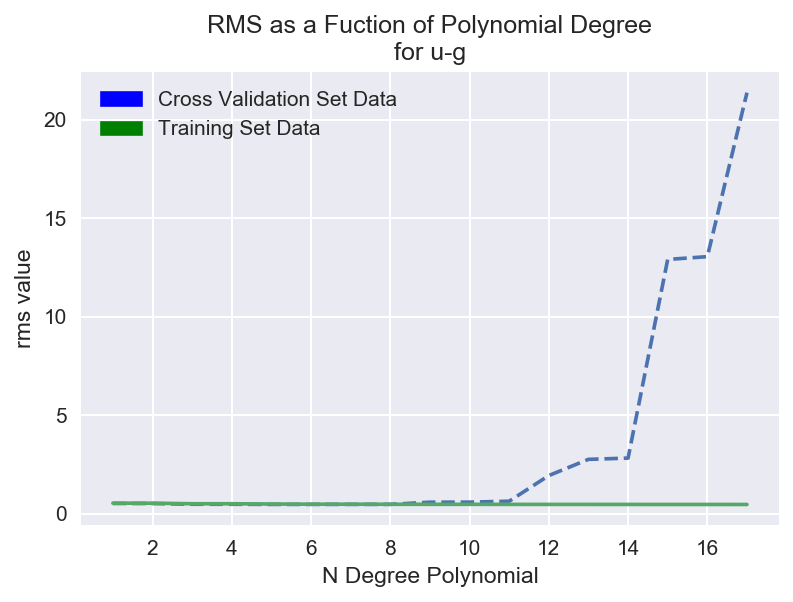

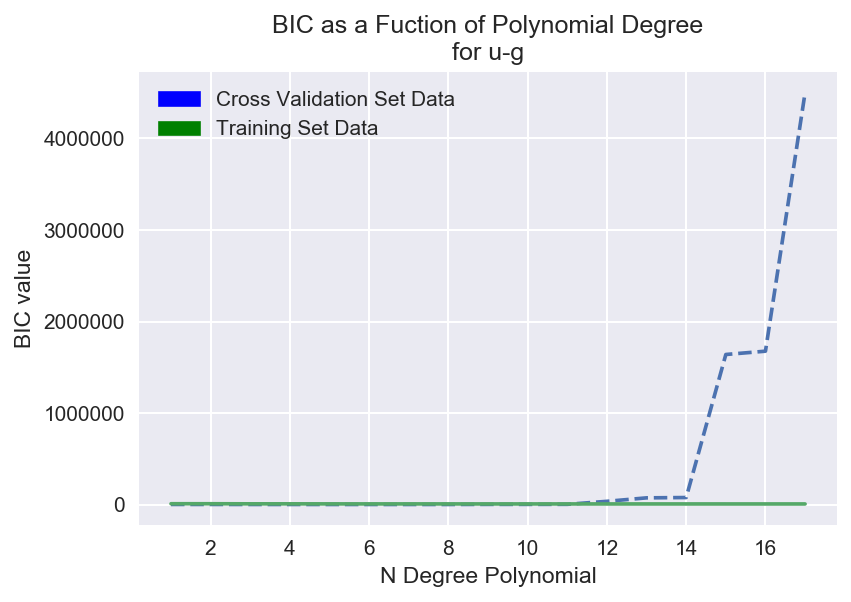

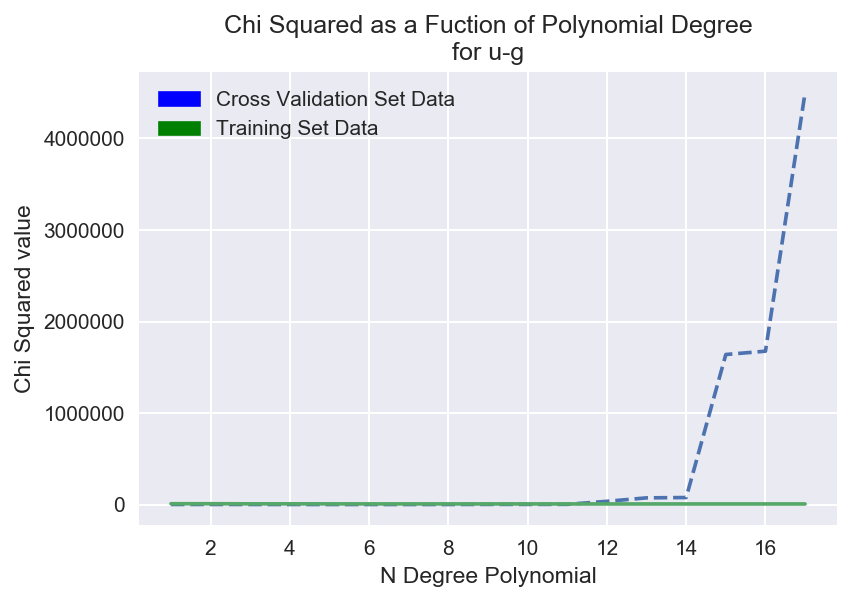

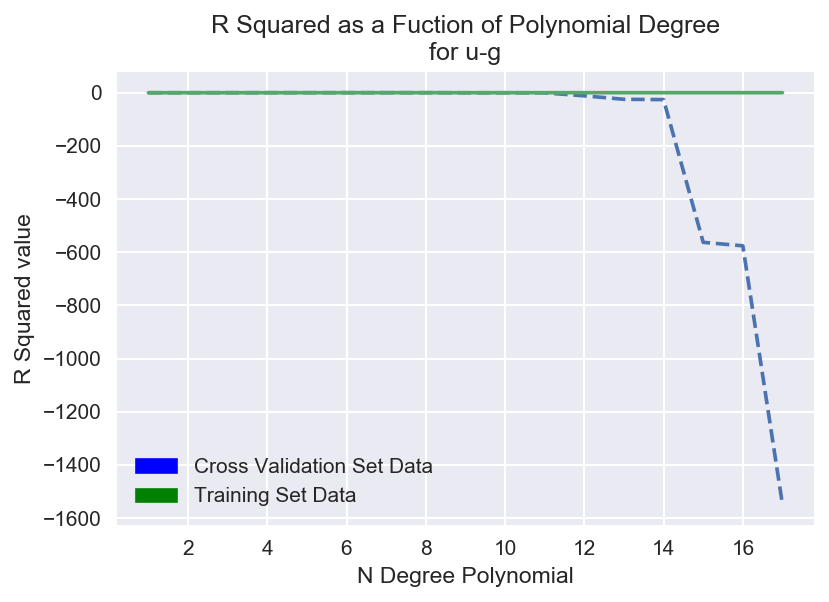

In [44]:
rms_cv = []
bic_cv =[]
chi_cv =[]
r2_cv = []

degrees = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

for d in degrees:
    poly = PolynomialRegression(d)
    poly.fit(x_train[:, None], y_train)
    y_fit = poly.predict(x_cv[:, None])

    #get values for BIC, RMS
    rms_cv.append(get_rms(y_cv,y_fit))
    bic_cv.append(get_bic(d,y_cv,y_fit))
    chi_cv.append(get_chi2(y_cv,y_fit,d))
    r2_cv.append(get_adj_r2(d,y_cv,y_fit))


rms_train = []
bic_train = []
chi_train = []
r2_train = []

for d in degrees:
    poly = PolynomialRegression(d)
    poly.fit(x_train[:, None], y_train)
    y_fit = poly.predict(x_train[:, None])
       
    #get values for BIC, RMS
    rms_train.append(get_rms(y_train,y_fit))
    bic_train.append(get_bic(d,y_train,y_fit))
    chi_train.append(get_chi2(y_train,y_fit,d))
    r2_train.append(get_adj_r2(d,y_train,y_fit))

plt.figure(dpi=150)
plt.plot(x_range,rms_cv, ls='dashed')
plt.plot(x_range,rms_train)

blue_patch = mpatches.Patch(color='blue', label='Cross Validation Set Data')
green_patch = mpatches.Patch(color='green', label='Training Set Data')
plt.legend(handles=[blue_patch, green_patch])
plt.title("RMS as a Fuction of Polynomial Degree\nfor u-g")
plt.xlabel("N Degree Polynomial")
plt.ylabel("rms value")
plt.savefig('u-g regression RMS')
plt.show()

plt.figure(dpi=150)
plt.plot(x_range,bic_cv, ls='dashed')
plt.plot(x_range,bic_train)
blue_patch = mpatches.Patch(color='blue', label='Cross Validation Set Data')
green_patch = mpatches.Patch(color='green', label='Training Set Data')
plt.legend(handles=[blue_patch, green_patch])
plt.title("BIC as a Fuction of Polynomial Degree\nfor u-g")
plt.xlabel("N Degree Polynomial")
plt.ylabel("BIC value")
plt.savefig('u-g regression BIC')
plt.show()

plt.figure(dpi=150)
plt.plot(x_range,chi_cv, ls='dashed')
plt.plot(x_range,chi_train)
blue_patch = mpatches.Patch(color='blue', label='Cross Validation Set Data')
green_patch = mpatches.Patch(color='green', label='Training Set Data')
plt.legend(handles=[blue_patch, green_patch])
plt.title("Chi Squared as a Fuction of Polynomial Degree\nfor u-g")
plt.xlabel("N Degree Polynomial")
plt.ylabel("Chi Squared value")
plt.savefig('u-g regression Chi')
plt.show()

plt.figure(dpi=150)
plt.plot(x_range,r2_cv, ls='dashed')
plt.plot(x_range,r2_train)
blue_patch = mpatches.Patch(color='blue', label='Cross Validation Set Data')
green_patch = mpatches.Patch(color='green', label='Training Set Data')
plt.legend(handles=[blue_patch, green_patch])
plt.title("R Squared as a Fuction of Polynomial Degree\nfor u-g")
plt.xlabel("N Degree Polynomial")
plt.ylabel("R Squared value")
plt.savefig('u-g regression R2')
plt.show()

# g-r

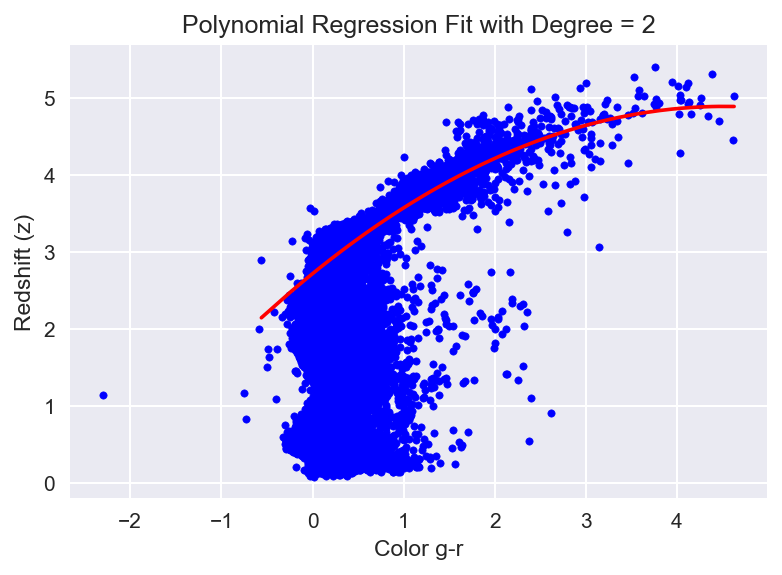

In [194]:
# above 2.5?

sorted_gr = sort(gr)[0]
red_gr = redshift[sort(gr)[1]]

zm = (red_gr > 2.5)
red_gr = red_gr[zm]
sorted_gr = sorted_gr[zm]

degrees = [2]
for d in degrees:
    x = sorted_gr
    y = red_gr
    y_fit = poly_regress(x, y, d)
    
    plt.figure(dpi=150)
    plt.plot(x, y_fit, color='red')
    plt.scatter(gr, redshift, color = 'blue' ,marker='.')
    plt.ylabel("Redshift (z)")
    plt.xlabel("Color g-r")
    plt.title("Polynomial Regression Fit with Degree = %.f" %d)
    plt.savefig('g-r FIT')
    plt.show()

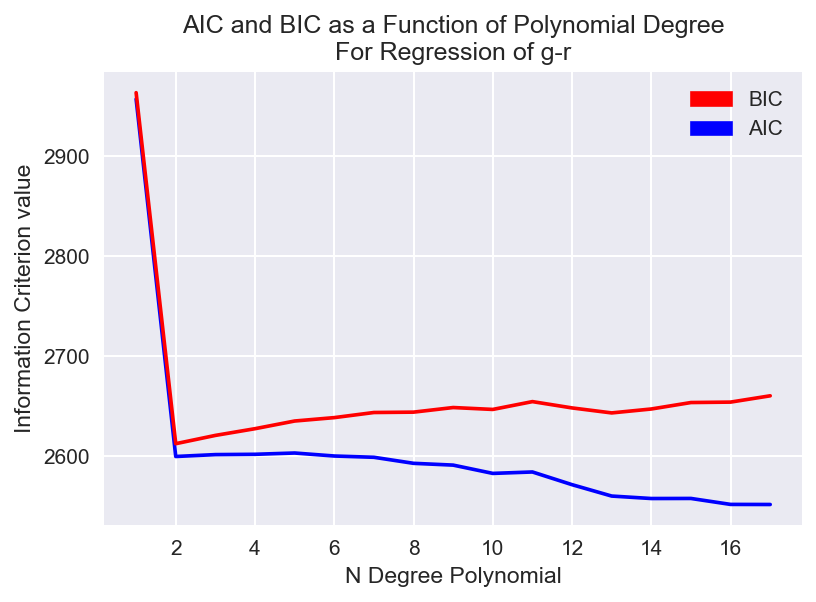

In [195]:
aic = []
bic = []
degrees = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

for d in degrees:
    x = sorted_gr
    y = red_gr
    y_fit = poly_regress(x, y, d)
    error = np.std(y)

    get_chi2(y,y_fit,d)
    aic.append(get_aic(d,y,y_fit))
    bic.append(get_bic(d,y,y_fit))

x_range = np.arange(1,18)
plt.figure(dpi=150)
plt.plot(x_range, aic, color='blue')
plt.plot(x_range, bic, color='red')

blue_patch = mpatches.Patch(color='blue', label='AIC')
red_patch = mpatches.Patch(color='red', label='BIC')

plt.legend(handles=[red_patch, blue_patch])
plt.title("AIC and BIC as a Function of Polynomial Degree\nFor Regression of g-r")
plt.ylabel('Information Criterion value')
plt.xlabel('N Degree Polynomial')
plt.savefig('g-r AIC  BIC')


plt.show()

In [45]:
# split up data into training and cross validation sets for ug

x_train, x_cv, y_train, y_cv = train_test_split(sorted_gr,red_gr,test_size= 0.2)


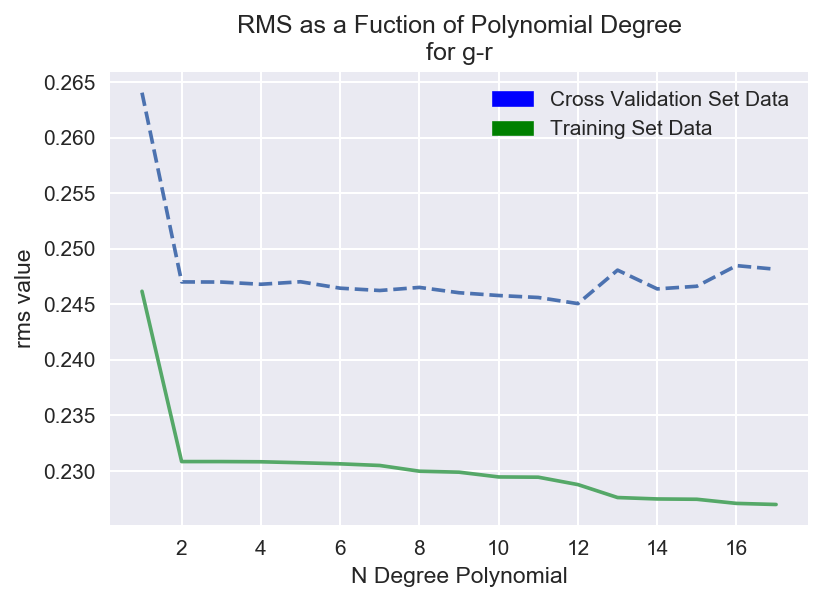

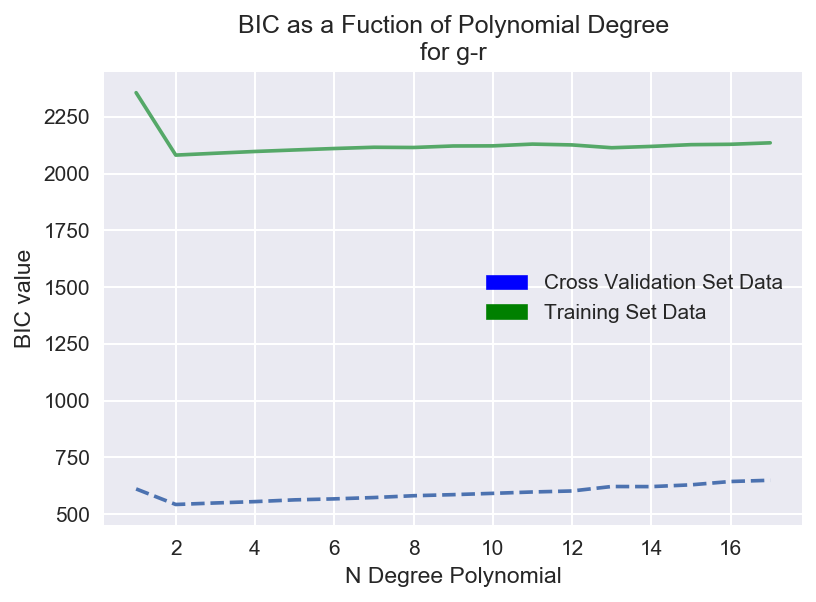

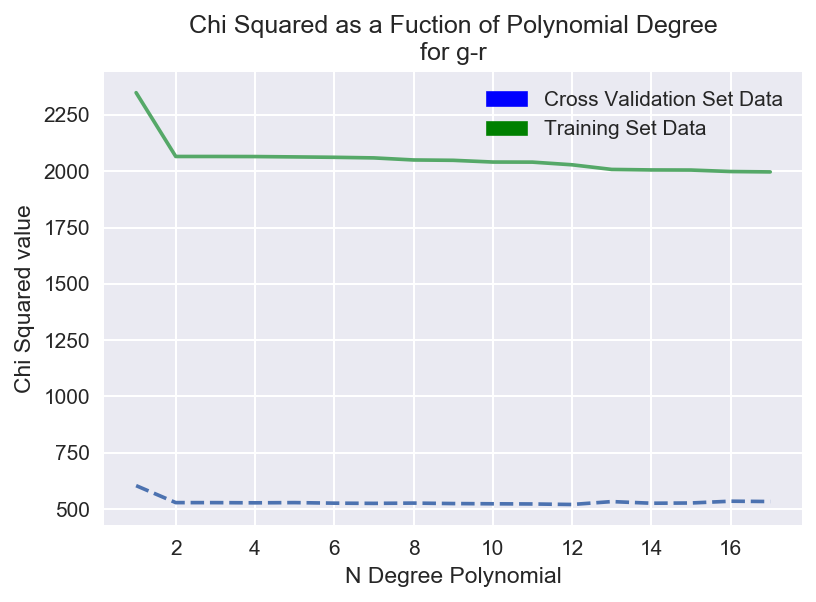

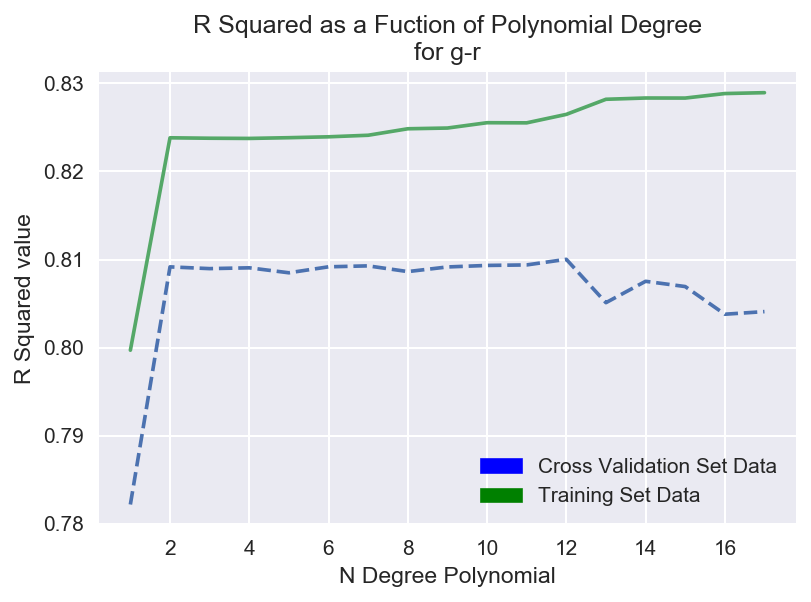

In [47]:
rms_cv = []
bic_cv =[]
chi_cv =[]
r2_cv = []

degrees = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

for d in degrees:
    poly = PolynomialRegression(d)
    poly.fit(x_train[:, None], y_train)
    y_fit = poly.predict(x_cv[:, None])

    #get values for BIC, RMS
    rms_cv.append(get_rms(y_cv,y_fit))
    bic_cv.append(get_bic(d,y_cv,y_fit))
    chi_cv.append(get_chi2(y_cv,y_fit,d))
    r2_cv.append(get_adj_r2(d,y_cv,y_fit))


rms_train = []
bic_train = []
chi_train = []
r2_train = []

for d in degrees:
    poly = PolynomialRegression(d)
    poly.fit(x_train[:, None], y_train)
    y_fit = poly.predict(x_train[:, None])
       
    #get values for BIC, RMS
    rms_train.append(get_rms(y_train,y_fit))
    bic_train.append(get_bic(d,y_train,y_fit))
    chi_train.append(get_chi2(y_train,y_fit,d))
    r2_train.append(get_adj_r2(d,y_train,y_fit))


plt.figure(dpi=150)
plt.plot(x_range,rms_cv, ls='dashed')
plt.plot(x_range,rms_train)

blue_patch = mpatches.Patch(color='blue', label='Cross Validation Set Data')
green_patch = mpatches.Patch(color='green', label='Training Set Data')
plt.legend(handles=[blue_patch, green_patch])
plt.title("RMS as a Fuction of Polynomial Degree\nfor g-r")
plt.xlabel("N Degree Polynomial")
plt.ylabel("rms value")
plt.savefig('g-r regression RMS')
plt.show()

plt.figure(dpi=150)
plt.plot(x_range,bic_cv, ls='dashed')
plt.plot(x_range,bic_train)
blue_patch = mpatches.Patch(color='blue', label='Cross Validation Set Data')
green_patch = mpatches.Patch(color='green', label='Training Set Data')
plt.legend(handles=[blue_patch, green_patch])
plt.title("BIC as a Fuction of Polynomial Degree\nfor g-r")
plt.xlabel("N Degree Polynomial")
plt.ylabel("BIC value")
plt.savefig('g-r regression BIC')
plt.show()

plt.figure(dpi=150)
plt.plot(x_range,chi_cv, ls='dashed')
plt.plot(x_range,chi_train)
blue_patch = mpatches.Patch(color='blue', label='Cross Validation Set Data')
green_patch = mpatches.Patch(color='green', label='Training Set Data')
plt.legend(handles=[blue_patch, green_patch])
plt.title("Chi Squared as a Fuction of Polynomial Degree\nfor g-r")
plt.xlabel("N Degree Polynomial")
plt.ylabel("Chi Squared value")
plt.savefig('g-r regression Chi')
plt.show()

plt.figure(dpi=150)
plt.plot(x_range,r2_cv, ls='dashed')
plt.plot(x_range,r2_train)
blue_patch = mpatches.Patch(color='blue', label='Cross Validation Set Data')
green_patch = mpatches.Patch(color='green', label='Training Set Data')
plt.legend(handles=[blue_patch, green_patch])
plt.title("R Squared as a Fuction of Polynomial Degree\nfor g-r")
plt.xlabel("N Degree Polynomial")
plt.ylabel("R Squared value")
plt.savefig('g-r regression R2')
plt.show()

# r-i

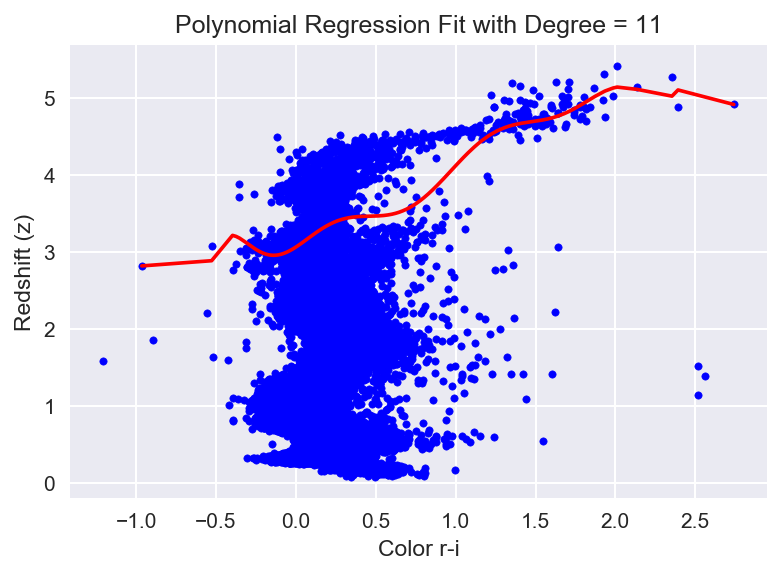

In [196]:
sorted_ri = sort(ri)[0]
red_ri= redshift[sort(ri)[1]]

zm = (red_ri > 2.5)
red_ri = red_ri[zm]
sorted_ri = sorted_ri[zm]

degrees = [11]
for d in degrees:
    x = sorted_ri
    y = red_ri
    y_fit = poly_regress(x, y, d)
    
    plt.figure(dpi=150)
    plt.plot(x, y_fit, color='red')
    plt.scatter(ri,redshift, color = 'blue', marker = '.')
    plt.ylabel("Redshift (z)")
    plt.xlabel("Color r-i")
    plt.title("Polynomial Regression Fit with Degree = %.f" %d)
    plt.savefig('r-i FIT')
    plt.show()

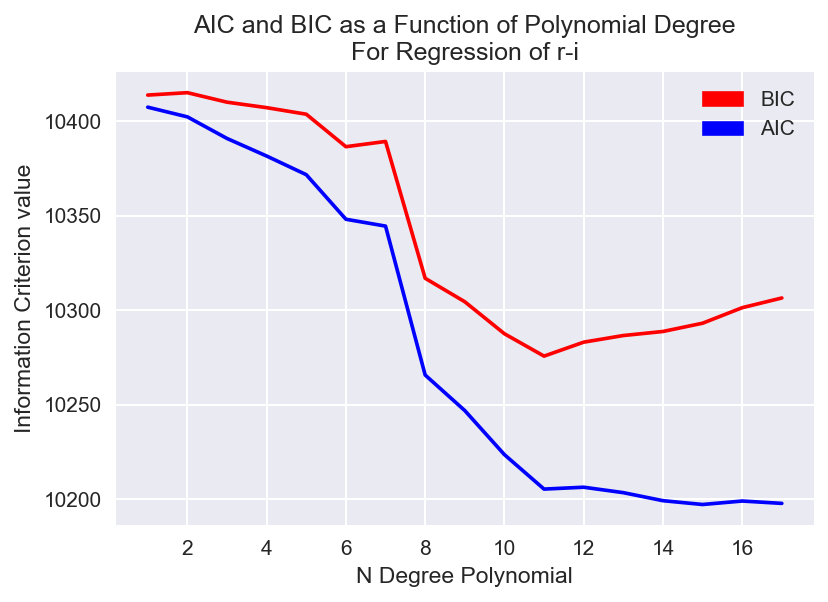

In [197]:
aic = []
bic = []
degrees = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

for d in degrees:
    x = sorted_ri
    y = red_ri
    y_fit = poly_regress(x, y, d)
    error = np.std(y)

    get_chi2(y,y_fit,d)
    aic.append(get_aic(d,y,y_fit))
    bic.append(get_bic(d,y,y_fit))

x_range = np.arange(1,18)

plt.figure(dpi=150)
plt.plot(x_range, aic, color='blue')
plt.plot(x_range, bic, color='red')

blue_patch = mpatches.Patch(color='blue', label='AIC')
red_patch = mpatches.Patch(color='red', label='BIC')

plt.legend(handles=[red_patch, blue_patch])
plt.title("AIC and BIC as a Function of Polynomial Degree\nFor Regression of r-i")
plt.ylabel('Information Criterion value')
plt.xlabel('N Degree Polynomial')
plt.savefig('r-i AIC bIC')

plt.show()

In [61]:
# split up data into training and cross validation sets for ug

x_train, x_cv, y_train, y_cv = train_test_split(sorted_ri, red_ri, test_size= 0.2)


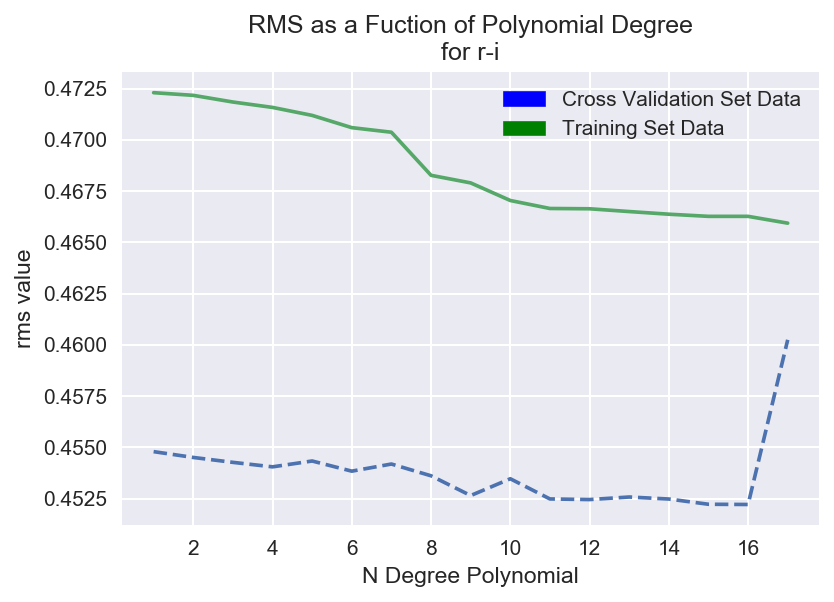

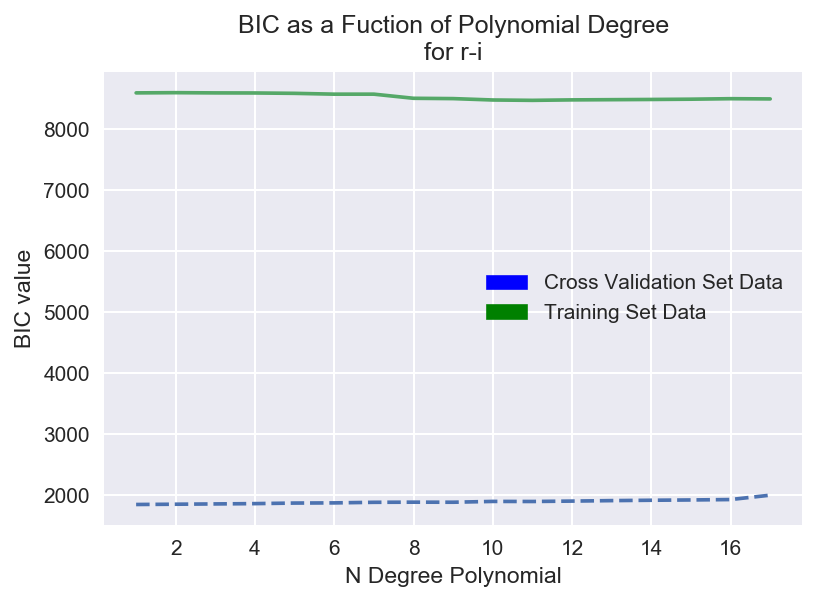

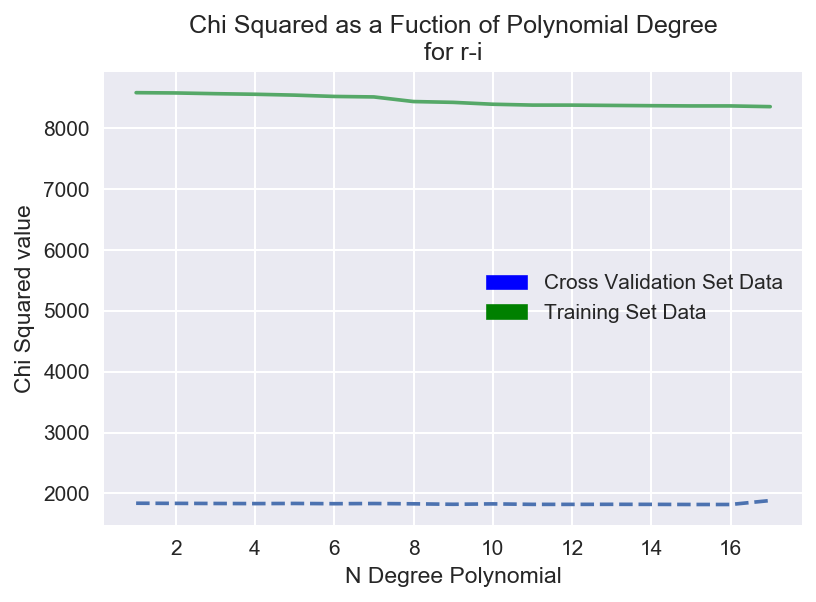

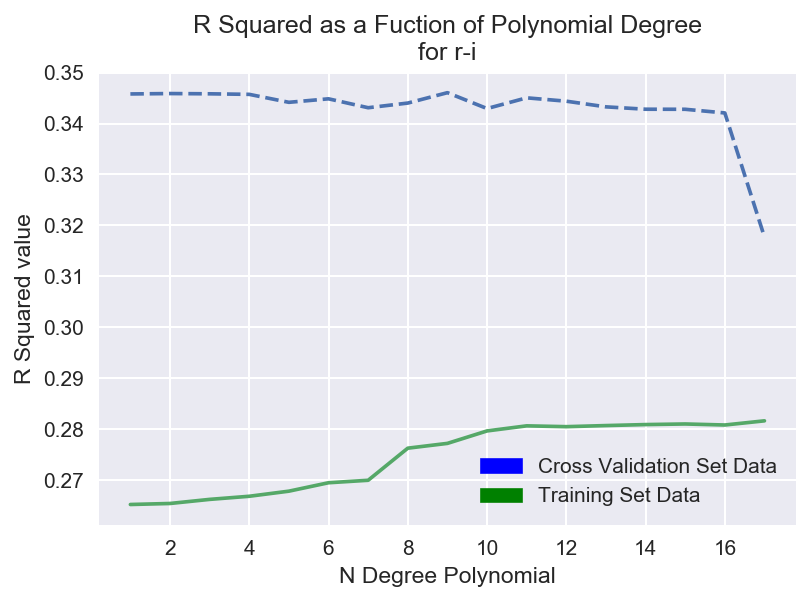

In [62]:
rms_cv = []
bic_cv =[]
chi_cv =[]
r2_cv = []

degrees = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

for d in degrees:
    poly = PolynomialRegression(d)
    poly.fit(x_train[:, None], y_train)
    y_fit = poly.predict(x_cv[:, None])

    #get values for BIC, RMS
    rms_cv.append(get_rms(y_cv,y_fit))
    bic_cv.append(get_bic(d,y_cv,y_fit))
    chi_cv.append(get_chi2(y_cv,y_fit,d))
    r2_cv.append(get_adj_r2(d,y_cv,y_fit))


rms_train = []
bic_train = []
chi_train = []
r2_train = []

for d in degrees:
    poly = PolynomialRegression(d)
    poly.fit(x_train[:, None], y_train)
    y_fit = poly.predict(x_train[:, None])
       
    #get values for BIC, RMS
    rms_train.append(get_rms(y_train,y_fit))
    bic_train.append(get_bic(d,y_train,y_fit))
    chi_train.append(get_chi2(y_train,y_fit,d))
    r2_train.append(get_adj_r2(d,y_train,y_fit))

plt.figure(dpi=150)
plt.plot(x_range,rms_cv, ls='dashed')
plt.plot(x_range,rms_train)

blue_patch = mpatches.Patch(color='blue', label='Cross Validation Set Data')
green_patch = mpatches.Patch(color='green', label='Training Set Data')
plt.legend(handles=[blue_patch, green_patch])
plt.title("RMS as a Fuction of Polynomial Degree\nfor r-i")
plt.xlabel("N Degree Polynomial")
plt.ylabel("rms value")
plt.savefig('r-i regression RMS')
plt.show()

plt.figure(dpi=150)
plt.plot(x_range,bic_cv, ls='dashed')
plt.plot(x_range,bic_train)
blue_patch = mpatches.Patch(color='blue', label='Cross Validation Set Data')
green_patch = mpatches.Patch(color='green', label='Training Set Data')
plt.legend(handles=[blue_patch, green_patch])
plt.title("BIC as a Fuction of Polynomial Degree\nfor r-i")
plt.xlabel("N Degree Polynomial")
plt.ylabel("BIC value")
plt.savefig('r-i regression BIC')
plt.show()

plt.figure(dpi=150)
plt.plot(x_range,chi_cv, ls='dashed')
plt.plot(x_range,chi_train)
blue_patch = mpatches.Patch(color='blue', label='Cross Validation Set Data')
green_patch = mpatches.Patch(color='green', label='Training Set Data')
plt.legend(handles=[blue_patch, green_patch])
plt.title("Chi Squared as a Fuction of Polynomial Degree\nfor r-i")
plt.xlabel("N Degree Polynomial")
plt.ylabel("Chi Squared value")
plt.savefig('r-i regression CHI')
plt.show()

plt.figure(dpi=150)
plt.plot(x_range,r2_cv, ls='dashed')
plt.plot(x_range,r2_train)
blue_patch = mpatches.Patch(color='blue', label='Cross Validation Set Data')
green_patch = mpatches.Patch(color='green', label='Training Set Data')
plt.legend(handles=[blue_patch, green_patch])
plt.title("R Squared as a Fuction of Polynomial Degree\nfor r-i")
plt.xlabel("N Degree Polynomial")
plt.ylabel("R Squared value")
plt.savefig('r-i regression R2')
plt.show()

# i-z

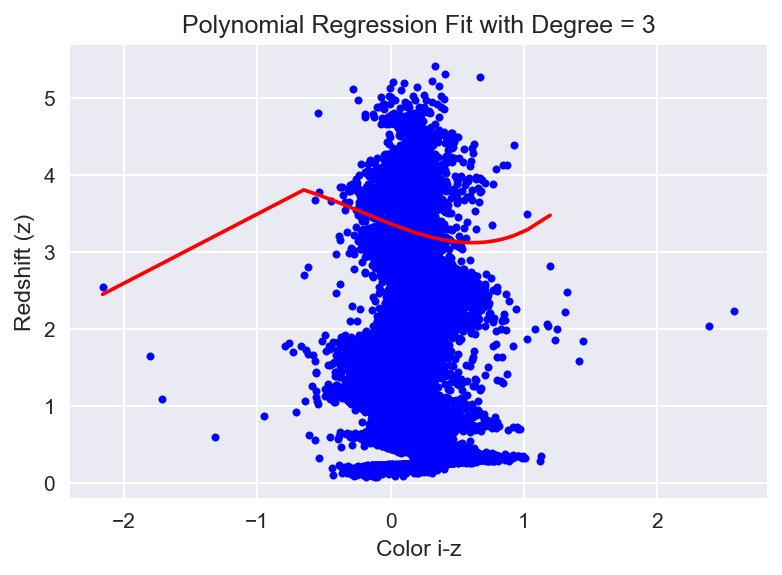

In [198]:
sorted_iz = sort(iz)[0]
red_iz = redshift[sort(iz)[1]]

zm = (red_iz > 2.5)
red_iz = red_iz[zm]
sorted_iz = sorted_iz[zm]

degrees = [3]
for d in degrees:
    x = sorted_iz
    y = red_iz
    y_fit = poly_regress(x, y, d)
    
    plt.figure(dpi=150)
    plt.plot(x, y_fit, color='red')
    plt.scatter(iz,redshift, color='blue', marker='.')
    plt.ylabel("Redshift (z)")
    plt.xlabel("Color i-z")
    plt.title("Polynomial Regression Fit with Degree = %.f" %d)
    plt.savefig('i-z FIT')
    plt.show()

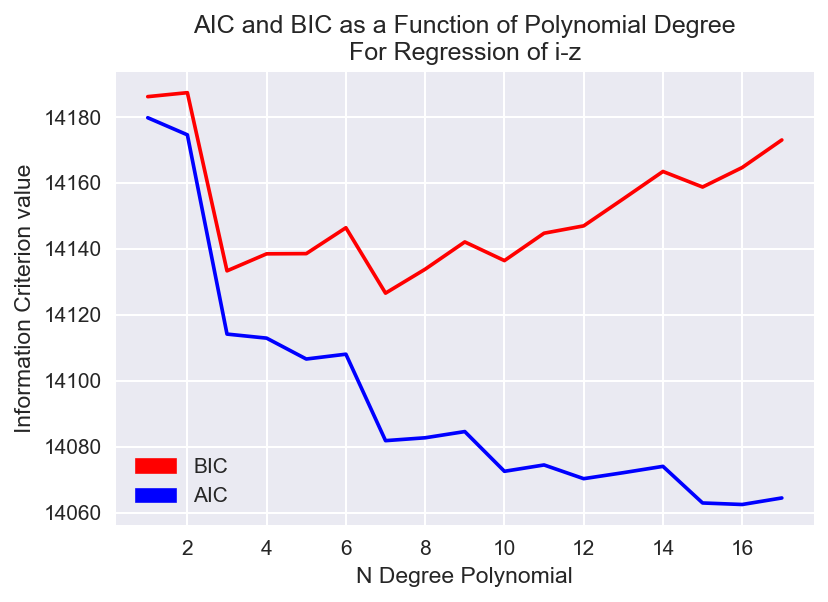

In [203]:
aic = []
bic = []
degrees = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

for d in degrees:
    x = sorted_iz
    y = red_iz
    y_fit = poly_regress(x, y, d)
    error = np.std(y)

    get_chi2(y,y_fit,d)
    aic.append(get_aic(d,y,y_fit))
    bic.append(get_bic(d,y,y_fit))

x_range = np.arange(1,18)
plt.figure(dpi=150)
plt.plot(x_range, aic, color='blue')
plt.plot(x_range, bic, color='red')

blue_patch = mpatches.Patch(color='blue', label='AIC')
red_patch = mpatches.Patch(color='red', label='BIC')

plt.legend(handles=[red_patch, blue_patch])
plt.title("AIC and BIC as a Function of Polynomial Degree\nFor Regression of i-z")
plt.ylabel('Information Criterion value')
plt.xlabel('N Degree Polynomial')
plt.savefig('i-z AIC BIC')
plt.show()

In [69]:
# split up data into training and cross validation sets for iz

x_train, x_cv, y_train, y_cv = train_test_split(sorted_iz, red_iz, test_size= 0.2)


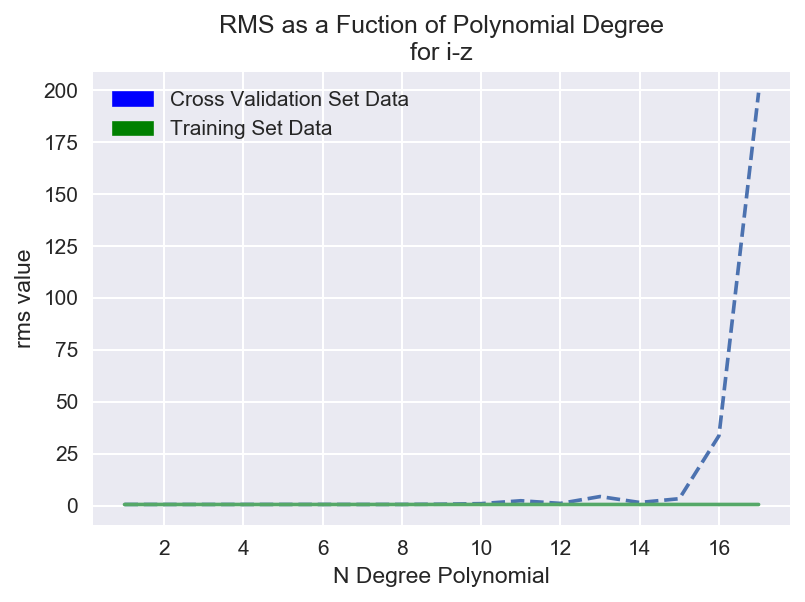

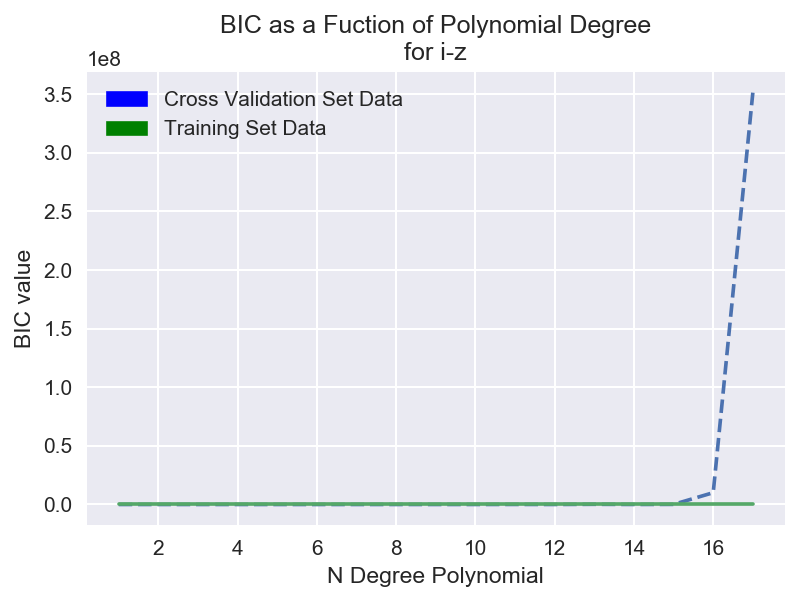

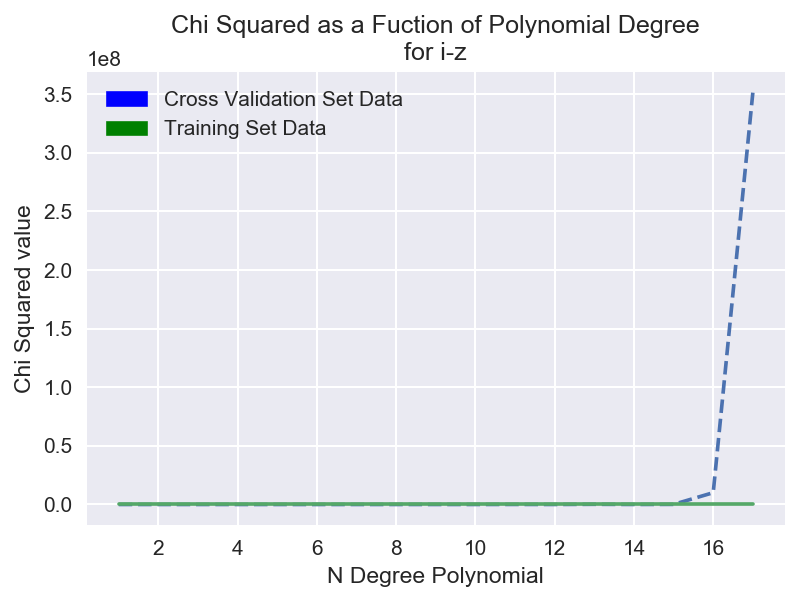

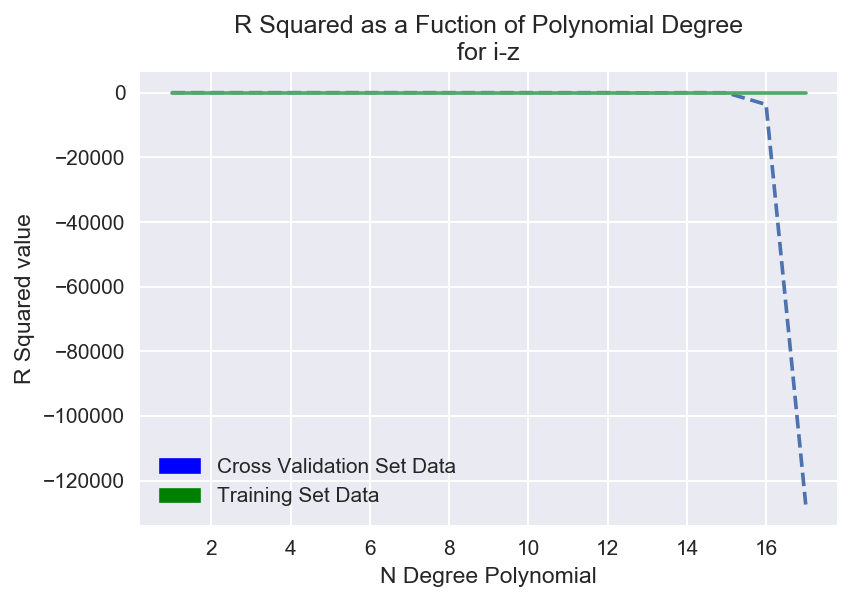

In [74]:
rms_cv = []
bic_cv =[]
chi_cv =[]
r2_cv = []

degrees = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

for d in degrees:
    poly = PolynomialRegression(d)
    poly.fit(x_train[:, None], y_train)
    y_fit = poly.predict(x_cv[:, None])

    #get values for BIC, RMS
    rms_cv.append(get_rms(y_cv,y_fit))
    bic_cv.append(get_bic(d,y_cv,y_fit))
    chi_cv.append(get_chi2(y_cv,y_fit,d))
    r2_cv.append(get_adj_r2(d,y_cv,y_fit))


rms_train = []
bic_train = []
chi_train = []
r2_train = []

for d in degrees:
    poly = PolynomialRegression(d)
    poly.fit(x_train[:, None], y_train)
    y_fit = poly.predict(x_train[:, None])
       
    #get values for BIC, RMS
    rms_train.append(get_rms(y_train,y_fit))
    bic_train.append(get_bic(d,y_train,y_fit))
    chi_train.append(get_chi2(y_train,y_fit,d))
    r2_train.append(get_adj_r2(d,y_train,y_fit))


plt.figure(dpi=150)
plt.plot(x_range,rms_cv, ls='dashed')
plt.plot(x_range,rms_train)

blue_patch = mpatches.Patch(color='blue', label='Cross Validation Set Data')
green_patch = mpatches.Patch(color='green', label='Training Set Data')
plt.legend(handles=[blue_patch, green_patch])
plt.title("RMS as a Fuction of Polynomial Degree\nfor i-z")
plt.xlabel("N Degree Polynomial")
plt.ylabel("rms value")
plt.savefig('i-z regression RMS')
plt.show()

plt.figure(dpi=150)
plt.plot(x_range,bic_cv, ls='dashed')
plt.plot(x_range,bic_train)
blue_patch = mpatches.Patch(color='blue', label='Cross Validation Set Data')
green_patch = mpatches.Patch(color='green', label='Training Set Data')
plt.legend(handles=[blue_patch, green_patch])
plt.title("BIC as a Fuction of Polynomial Degree\nfor i-z")
plt.xlabel("N Degree Polynomial")
plt.ylabel("BIC value")
plt.savefig('i-z regression BIC')
plt.show()

plt.figure(dpi=150)
plt.plot(x_range,chi_cv, ls='dashed')
plt.plot(x_range,chi_train)
blue_patch = mpatches.Patch(color='blue', label='Cross Validation Set Data')
green_patch = mpatches.Patch(color='green', label='Training Set Data')
plt.legend(handles=[blue_patch, green_patch])
plt.title("Chi Squared as a Fuction of Polynomial Degree\nfor i-z")
plt.xlabel("N Degree Polynomial")
plt.ylabel("Chi Squared value")
plt.savefig('i-z regression CHI')
plt.show()

plt.figure(dpi=150)
plt.plot(x_range,r2_cv, ls='dashed')
plt.plot(x_range,r2_train)
blue_patch = mpatches.Patch(color='blue', label='Cross Validation Set Data')
green_patch = mpatches.Patch(color='green', label='Training Set Data')
plt.legend(handles=[blue_patch, green_patch])
plt.title("R Squared as a Fuction of Polynomial Degree\nfor i-z")
plt.xlabel("N Degree Polynomial")
plt.ylabel("R Squared value")
plt.savefig('i-z regression R2')
plt.show()

# Hypothesis Testing - Outliers

let's visualize the data

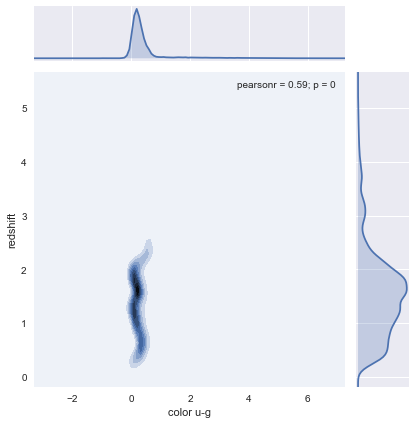

In [80]:
import pandas as pd
zipped = zip(ug, redshift)
df = pd.DataFrame(list(zipped), columns=['color u-g', 'redshift'])

sns.jointplot(x='color u-g', y='redshift', data=df, kind="kde");


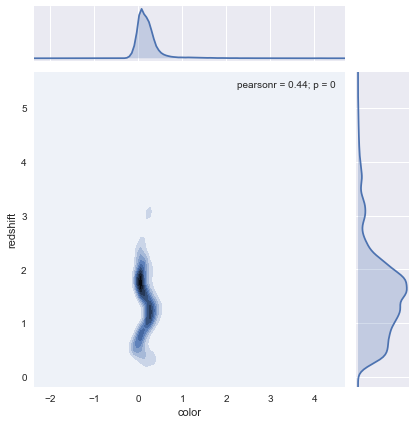

In [81]:
zipped = zip(gr, redshift)
df = pd.DataFrame(list(zipped), columns=['color', 'redshift'])

sns.jointplot(x='color', y='redshift', data=df, kind="kde");

We know from the Weinstein et al. paper that there are certain quasars that are reddened, since they are considerably redder than other quasars at a similar redshift. We will analyze the data to see if we can find these. This tends to happen at u-g and g-r, so we will focus on these two cases specifically.

In [95]:
# lets partition our redshifts and look at average value for each of those
# we will do them in 1/5 steps - by eye we see where majority of redenning occurs

red_values = sort(redshift)[0]
indices = sort(redshift)[1]

# make a function to split
def split(array):
    for x in array:
        sec_1 = x[:9284]
        slice_1.append(sec_1)
        sec_2 = x[9284:18568]
        slice_2.append(sec_2)
        sec_3 = x[18568:27852]
        slice_3.append(sec_3)
        sec_4 = x[27852:37136]
        slice_4.append(sec_4)
        sec_5 = x[37136:len(red_values)]
        slice_5.append(sec_5)
        
# make a function for zscore
def get_zscore(x, obs):
    stddev = np.std(x)
    mean = np.mean(x)
    z = (obs-mean)/stddev
    return z 

# make a function for pscore
def get_pscore(z):
    pscore = 1 - (st.norm.cdf(z))
    return pscore

In [96]:
# lets do this for u-g

ug_values = ug[indices]
array = [ug_values,red_values]

slice_1 = []
slice_2 = []
slice_3 = []
slice_4 = []
slice_5 = []
      
split(array)

NameError: name 'plt' is not defined

# u-g outliers

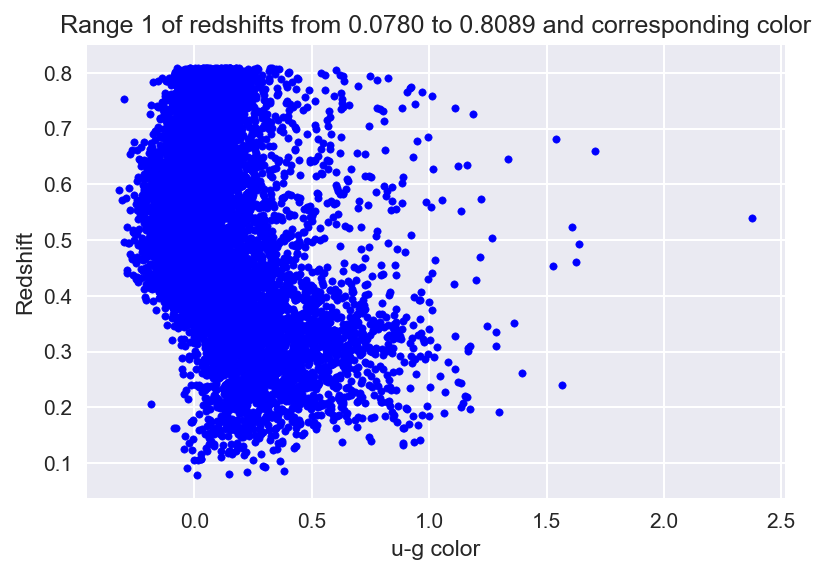

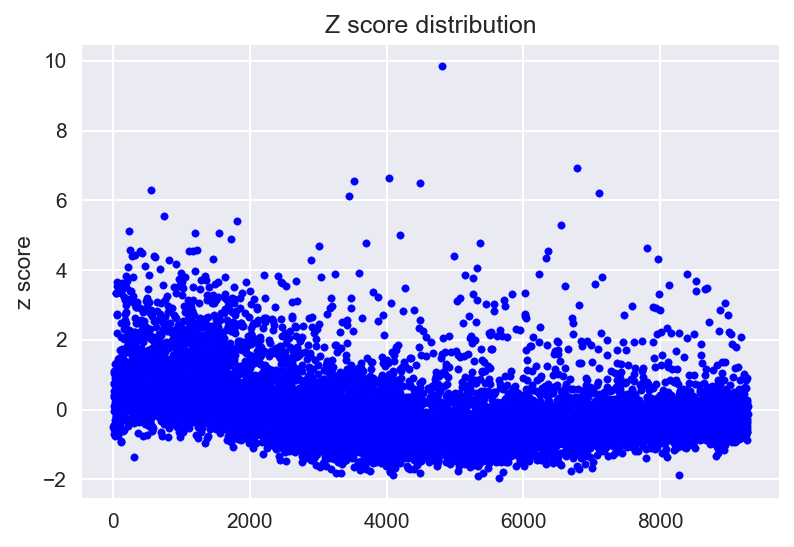

The number of outliers in the first fifth of redshifts is 42
The average p-score of the proposed outliers is 0.000005 meaning we can reject the null hypothesis that the observation happened by chance


In [162]:
# SLICE 1

ug_slice1 = slice_1[0]
red_slice1 = slice_1[1]

color = ug_slice1
red = red_slice1

range_min = np.min(red)
range_max = np.max(red)

plt.figure(dpi=150)
plt.scatter(color,red, color='blue', marker='.')
plt.title("Range 1 of redshifts from %.4f to %.4f and corresponding color" % (range_min, range_max))
plt.xlabel("u-g color")
plt.ylabel("Redshift")
plt.savefig('u-g range 1')
plt.show()

# get z-scores
zscores = []
for x in color:
    z = get_zscore(color, x)
    zscores.append(z)

# visualize zscores
plt.figure(dpi=150)
plt.scatter(np.arange(1,9285), zscores, color='blue', marker='.')
plt.title("Z score distribution")
plt.ylabel("z score")
plt.savefig('u-g range 1 zscores')
plt.show()

high_zscores = []
for z  in zscores:
    if z>4:
        high_zscores.append(z)
        
# convert to p-score:
pscores = []
for z in high_zscores:
    pscore = get_pscore(z)
    pscores.append(pscore)
    
mean_pscore = np.mean(pscores)
print ("The number of outliers in the first fifth of redshifts is %.0f" % (len(high_zscores)))
print ("The average p-score of the proposed outliers is %f meaning we can reject the null hypothesis that the observation happened by chance" %(mean_pscore))

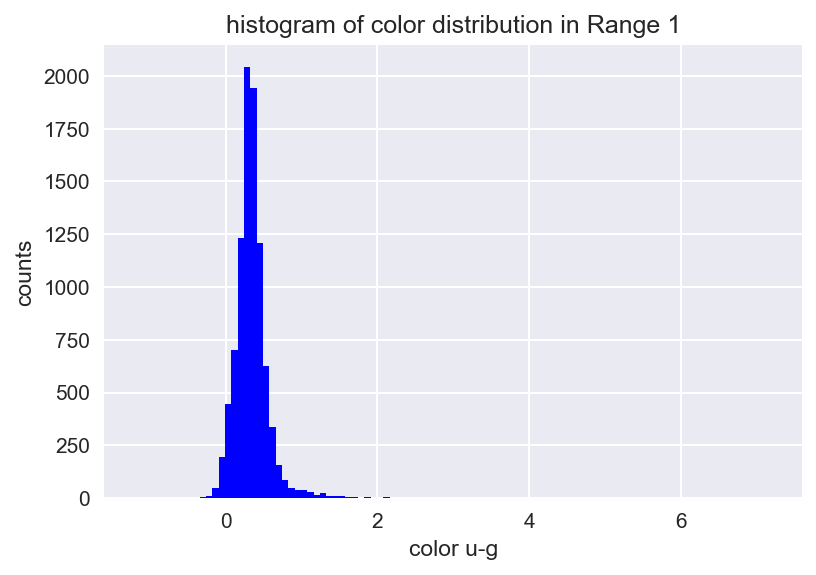

In [98]:
#sns.distplot(color, hist = False, kde = True, rug = True, color = 'darkblue')
plt.figure(dpi=150)
plt.hist(color, bins=100, color='blue')
plt.ylabel('counts')
plt.xlabel("color u-g")
plt.title('histogram of color distribution in Range 1')
plt.savefig('u-g range 1 hist')

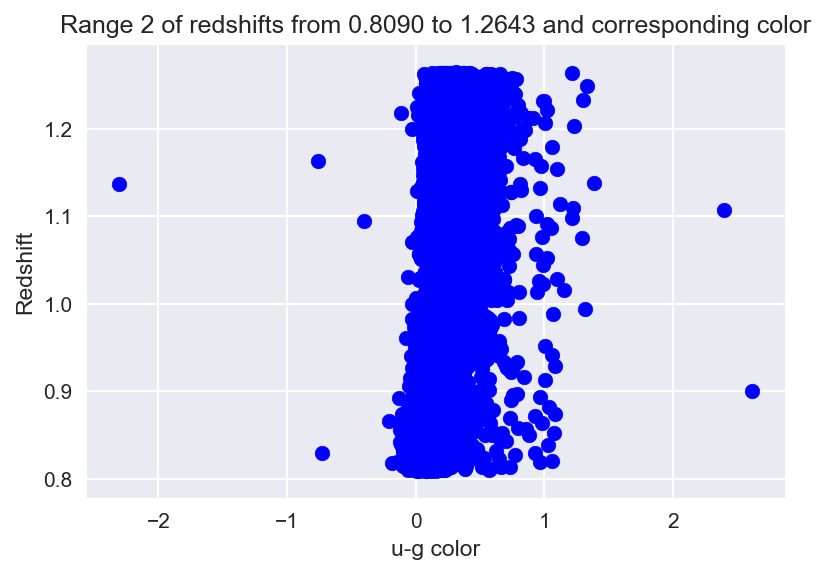

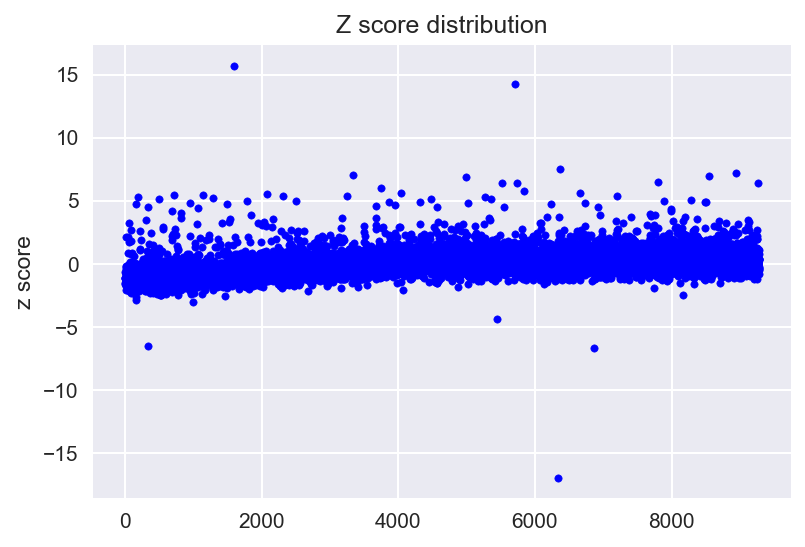

The number of outliers in the second fifth of redshifts is 52


In [164]:
# SLICE 2

ug_slice2 = slice_2[0]
red_slice2 = slice_2[1]

color = ug_slice2
red = red_slice2

range_min = np.min(red)
range_max = np.max(red)

plt.figure(dpi=150)
plt.scatter(color,red, color='blue')
plt.title("Range 2 of redshifts from %.4f to %.4f and corresponding color" % (range_min, range_max))
plt.xlabel("u-g color")
plt.ylabel("Redshift")
plt.savefig('u-g range 2')
plt.show()

# get z-scores
zscores = []
for x in color:
    z = get_zscore(color, x)
    zscores.append(z)
    
# visualize zscores
plt.figure(dpi=150)
plt.scatter(np.arange(1,9285), zscores, color='blue',marker='.')
plt.title("Z score distribution")
plt.ylabel("z score")
#plt.savefig('u-g range 2 zscores')
plt.show()

high_zscores = []
for z  in zscores:
    if z>4:
        high_zscores.append(z)
print ("The number of outliers in the second fifth of redshifts is %.0f" % (len(high_zscores)))

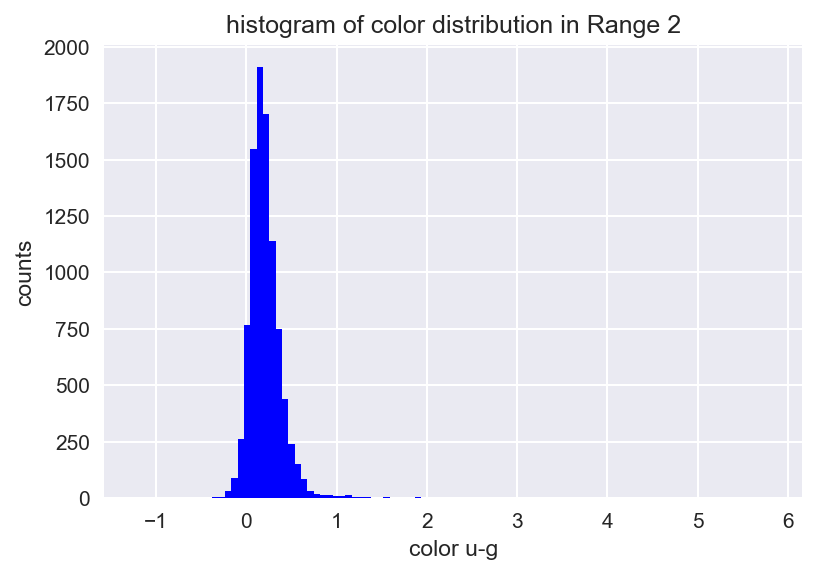

In [108]:
plt.figure(dpi=150)
plt.hist(color, bins=100, color='blue')
plt.ylabel('counts')
plt.xlabel("color u-g")
plt.title('histogram of color distribution in Range 2')
plt.savefig('u-g range 2 hist')

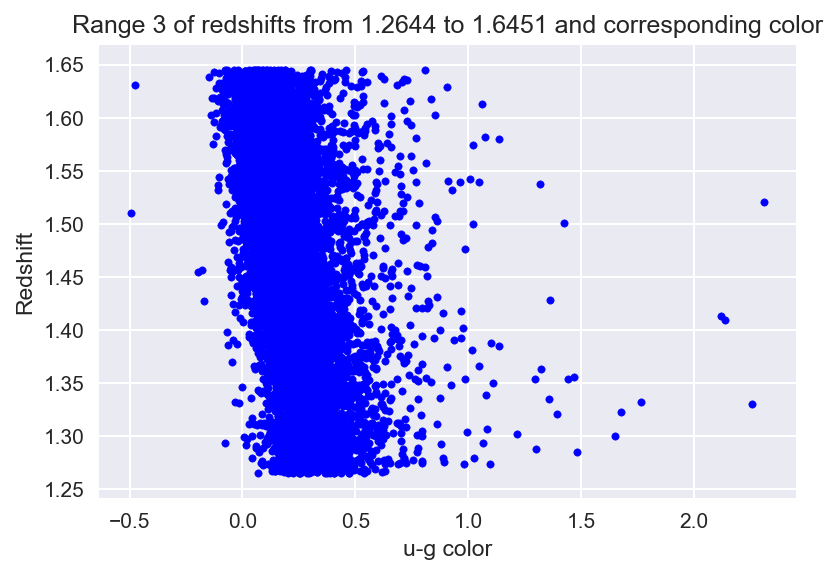

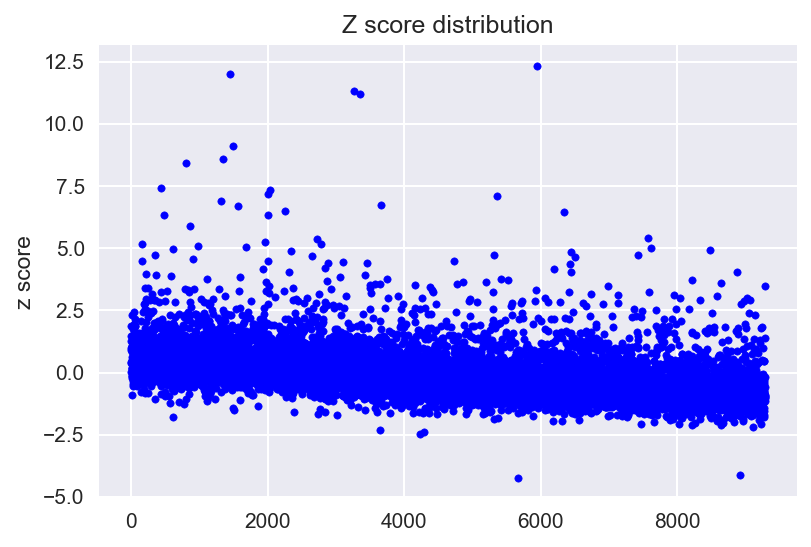

The number of outliers in the third fifth of redshifts is 50
The average p-score of the proposed outliers is 0.000003 meaning we can reject the null hypothesis that the observation happened by chance


In [166]:
# SLICE 3

ug_slice3 = slice_3[0]
red_slice3 = slice_3[1]

color = ug_slice3
red = red_slice3


range_min = np.min(red)
range_max = np.max(red)

plt.figure(dpi=150)
plt.scatter(color,red, color='blue', marker='.')
plt.title("Range 3 of redshifts from %.4f to %.4f and corresponding color" % (range_min, range_max))
plt.xlabel("u-g color")
plt.ylabel("Redshift")
#plt.savefig('u-g range 3')
plt.show()

# get z-scores
zscores = []
for x in color:
    z = get_zscore(color, x)
    zscores.append(z)

# visualize zscores
plt.figure(dpi=150)
plt.scatter(np.arange(1,9285), zscores, color='blue', marker='.')
plt.title("Z score distribution")
plt.ylabel("z score")
#plt.savefig('u-g range 3 zscores')
plt.show()

high_zscores = []
for z  in zscores:
    if z>4:
        high_zscores.append(z)
        
# convert to p-score:
pscores = []
for z in high_zscores:
    pscore = get_pscore(z)
    pscores.append(pscore)
    
mean_pscore = np.mean(pscores)
print ("The number of outliers in the third fifth of redshifts is %.0f" % (len(high_zscores)))
print ("The average p-score of the proposed outliers is %f meaning we can reject the null hypothesis that the observation happened by chance" %(mean_pscore))

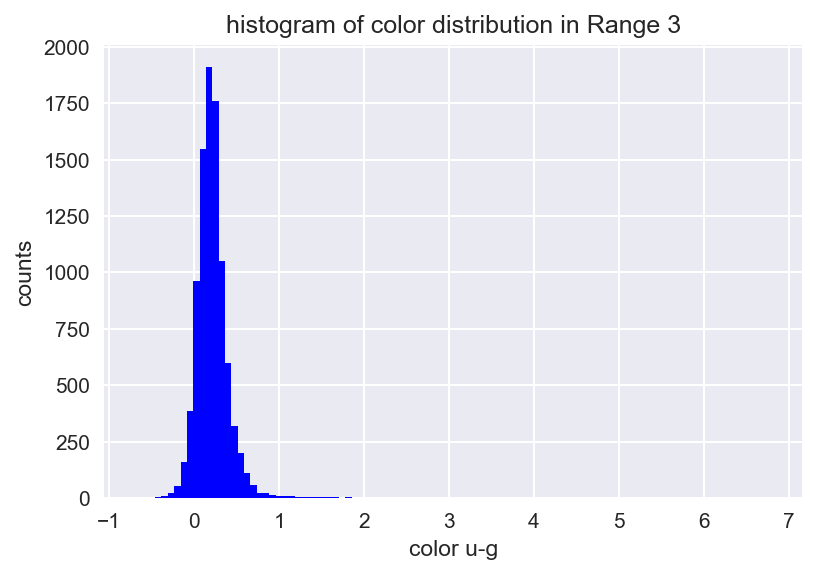

In [118]:
plt.figure(dpi=150)
plt.hist(color, bins=100, color='blue')
plt.ylabel('counts')
plt.xlabel("color u-g")
plt.title('histogram of color distribution in Range 3')
plt.savefig('u-g range 3 hist')

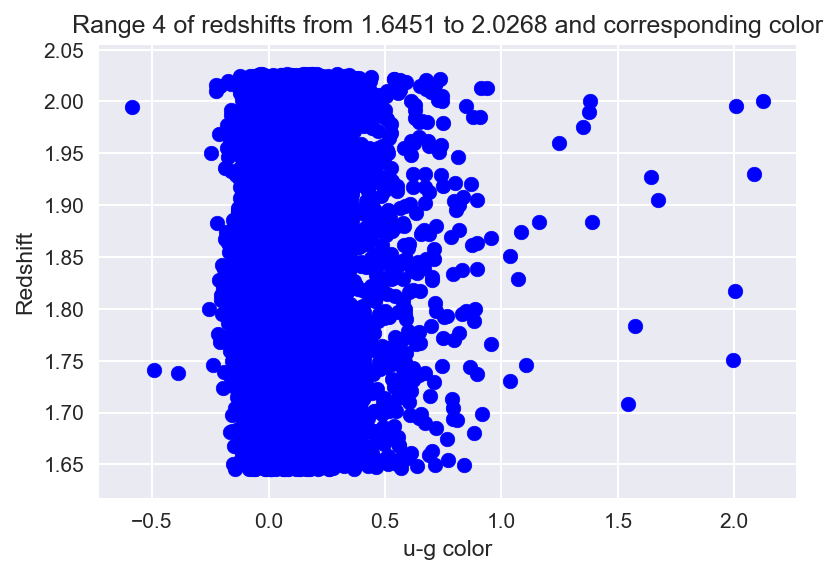

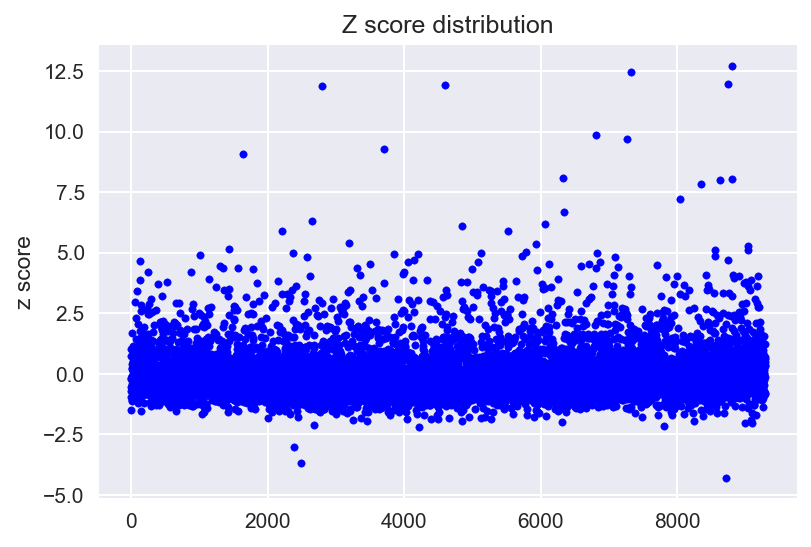

The number of outliers in the fourth fifth of redshifts is 70


In [168]:
# SLICE 4

ug_slice4 = slice_4[0]
red_slice4 = slice_4[1]

color = ug_slice4
red = red_slice4

range_min = np.min(red)
range_max = np.max(red)

plt.figure(dpi = 150)
plt.scatter(color,red, color='blue')
plt.title("Range 4 of redshifts from %.4f to %.4f and corresponding color" % (range_min, range_max))
plt.xlabel("u-g color")
plt.ylabel("Redshift")
#plt.savefig('u-g range 4')
plt.show()

# get z-scores
zscores = []
for x in color:
    z = get_zscore(color, x)
    zscores.append(z)
    
# visualize zscores
plt.figure(dpi=150)
plt.scatter(np.arange(1,9285), zscores,color='blue', marker='.')
plt.title("Z score distribution")
plt.ylabel("z score")
#plt.savefig('u-g range 4 scores')
plt.show()

high_zscores = []
for z  in zscores:
    if z>4:
        high_zscores.append(z)
print ("The number of outliers in the fourth fifth of redshifts is %.0f" % (len(high_zscores)))

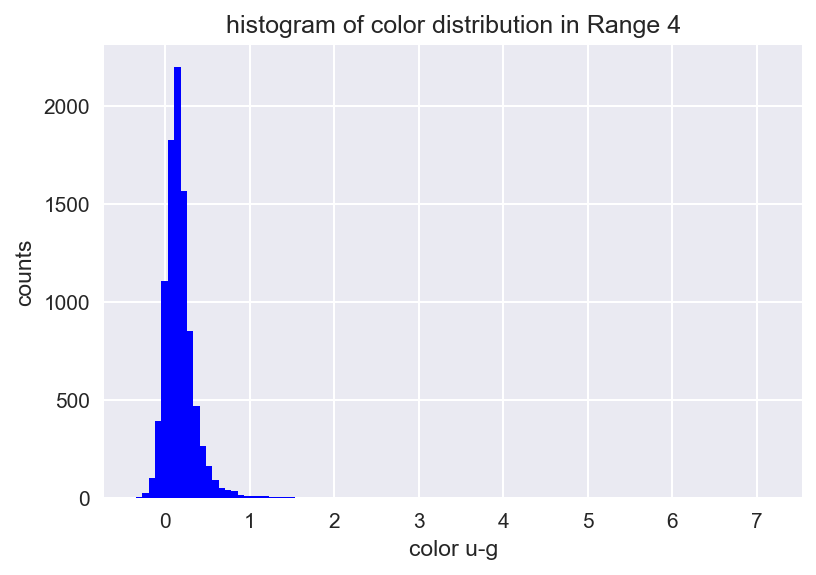

In [120]:
plt.figure(dpi=150)
plt.hist(color, bins=100, color='blue')
plt.ylabel('counts')
plt.xlabel("color u-g")
plt.title('histogram of color distribution in Range 4')
plt.savefig('u-g range 4 hist')

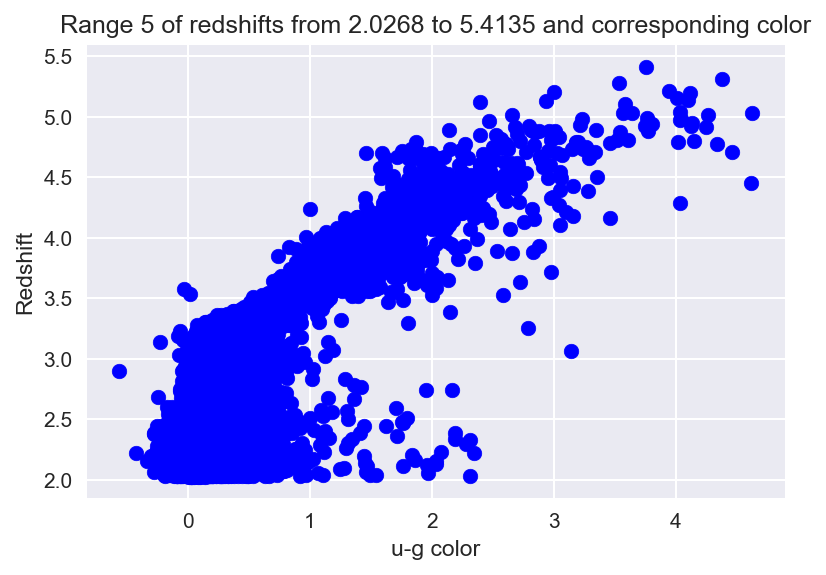

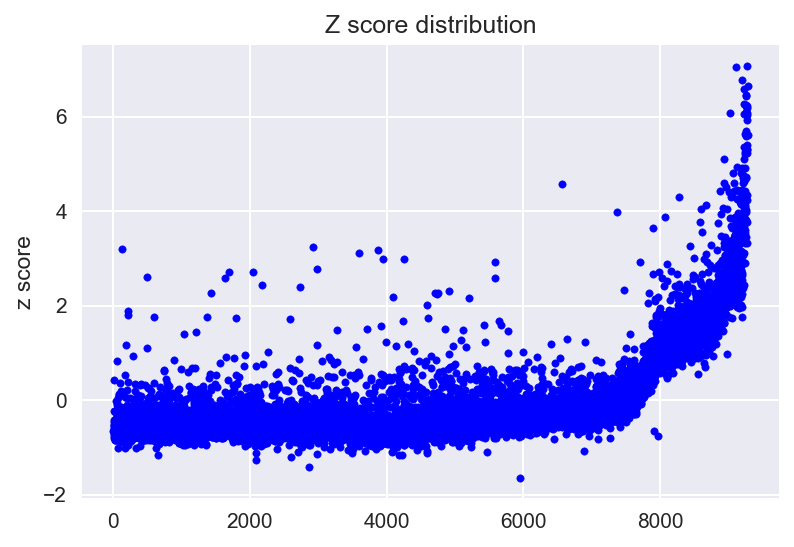

The number of outliers in the last fifth of redshifts is 83


In [169]:
# SLICE 5

ug_slice5 = slice_5[0]
red_slice5 = slice_5[1]

color = ug_slice5
red = red_slice5

range_min = np.min(red)
range_max = np.max(red)

plt.figure(dpi=150)
plt.scatter(color,red, color='blue')
plt.title("Range 5 of redshifts from %.4f to %.4f and corresponding color" % (range_min, range_max))
plt.xlabel("u-g color")
plt.ylabel("Redshift")
#plt.savefig('u-g range 5')
plt.show()

# get z-scores
zscores = []
for x in color:
    z = get_zscore(color, x)
    zscores.append(z)
    
# visualize zscores
plt.figure(dpi=150)
plt.scatter(np.arange(1,9285), zscores, color='blue', marker='.')
plt.title("Z score distribution")
plt.ylabel("z score")
#plt.savefig('u-g range 5 zscores')
plt.show()

high_zscores = []
for z  in zscores:
    if z>4:
        high_zscores.append(z)
print ("The number of outliers in the last fifth of redshifts is %.0f" % (len(high_zscores)))

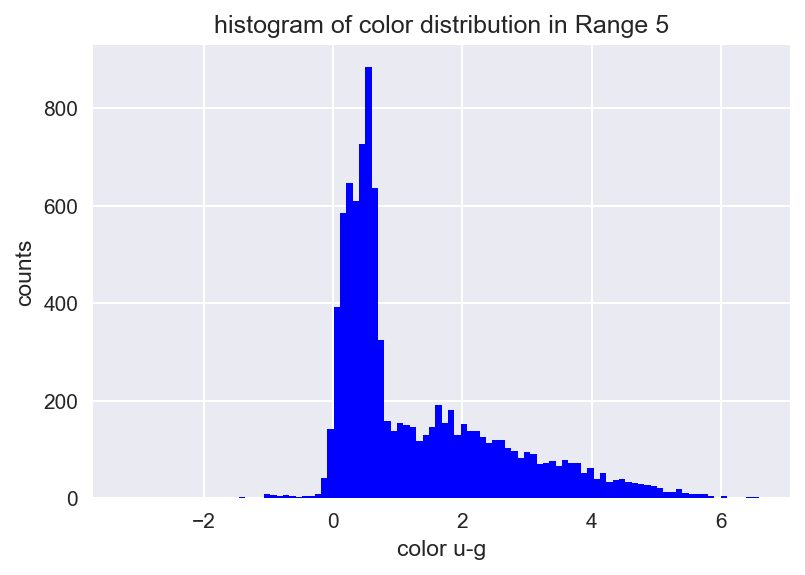

In [122]:
plt.figure(dpi=150)
plt.hist(color, bins=100, color='blue')
plt.ylabel('counts')
plt.xlabel("color u-g")
plt.title('histogram of color distribution in Range 5')
plt.savefig('u-g range 5 hist')

reddening decreases as we increase in redshift, but scatter also increases due to dust reddening

# plot a histogram -- what if we increase threshold? (z = 5) calculate p

# g-r outliers

In [123]:
# now lets do this for g-r

gr_values = gr[indices]

array = [gr_values, red_values]
slice_1 = []
slice_2 = []
slice_3 = []
slice_4 = []
slice_5 = []

split(array)

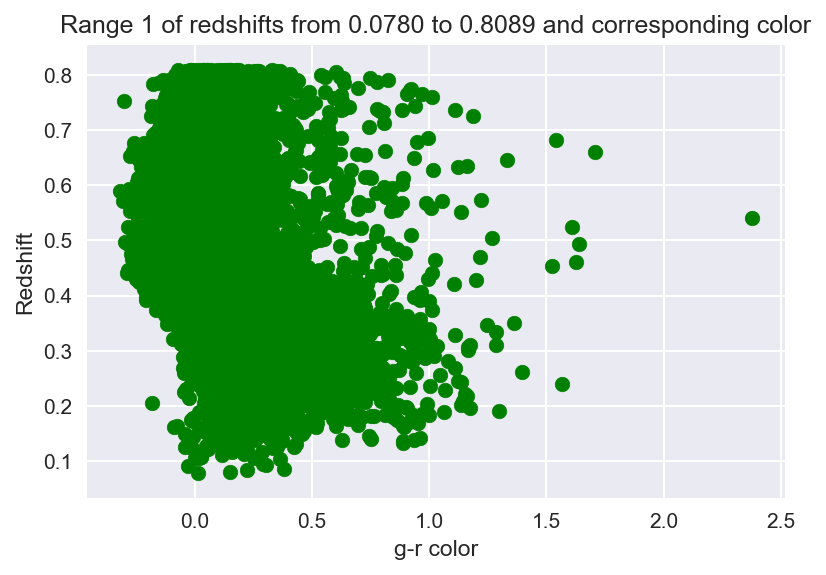

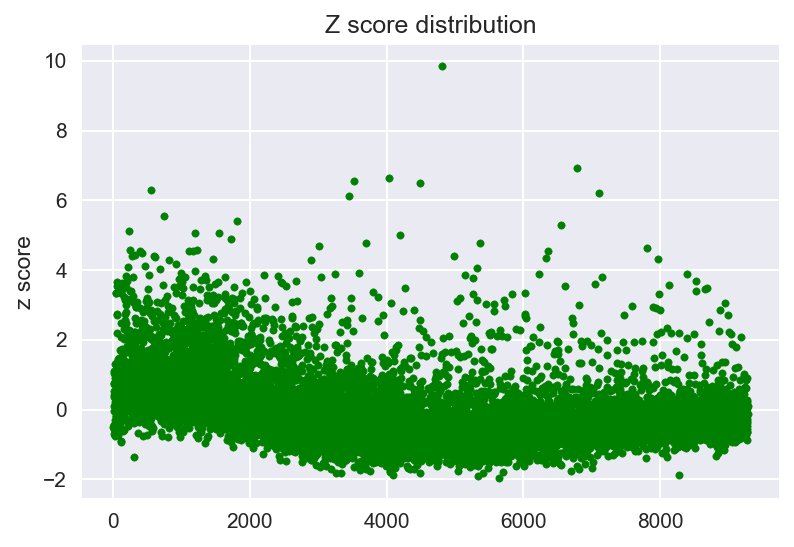

The number of outliers in the first fifth of redshifts is 42


In [170]:
# SLICE 1

gr_slice1 = slice_1[0]
red_slice1 = slice_1[1]

color = gr_slice1
red = red_slice1

range_min = np.min(red)
range_max = np.max(red)

plt.figure(dpi=150)
plt.scatter(color,red, color='green')
plt.title("Range 1 of redshifts from %.4f to %.4f and corresponding color" % (range_min, range_max))
plt.xlabel("g-r color")
plt.ylabel("Redshift")
#plt.savefig('g-r range 1')
plt.show()

# get z-scores
zscores = []
for x in color:
    z = get_zscore(color, x)
    zscores.append(z)
    
# visualize zscores
plt.figure(dpi=150)
plt.scatter(np.arange(1,9285), zscores, color='green',marker='.')
plt.title("Z score distribution")
plt.ylabel("z score")
#plt.savefig('g-r range 1 zscores')
plt.show()

high_zscores = []
for z  in zscores:
    if z>4:
        high_zscores.append(z)
print ("The number of outliers in the first fifth of redshifts is %.0f" % (len(high_zscores)))

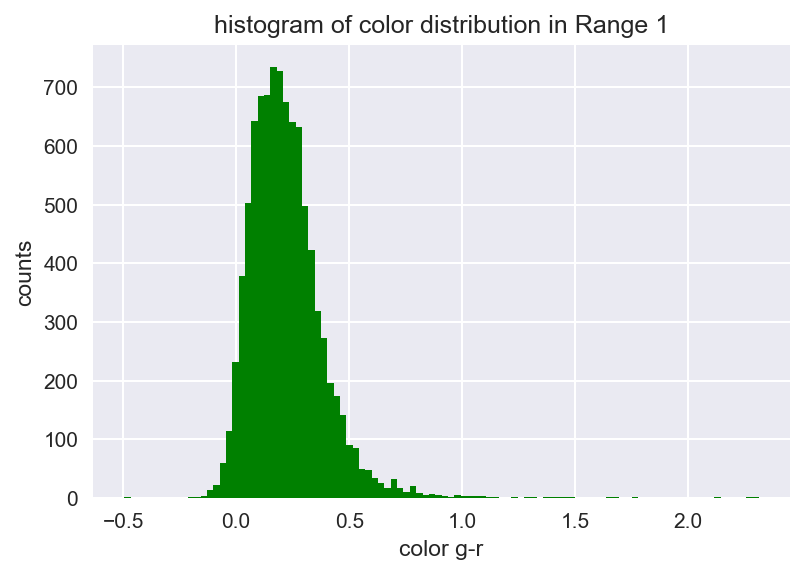

In [140]:
plt.figure(dpi=150)
plt.hist(color, bins=100, color='green')
plt.ylabel('counts')
plt.xlabel("color g-r")
plt.title('histogram of color distribution in Range 1')
plt.savefig('g-r range 1 hist')

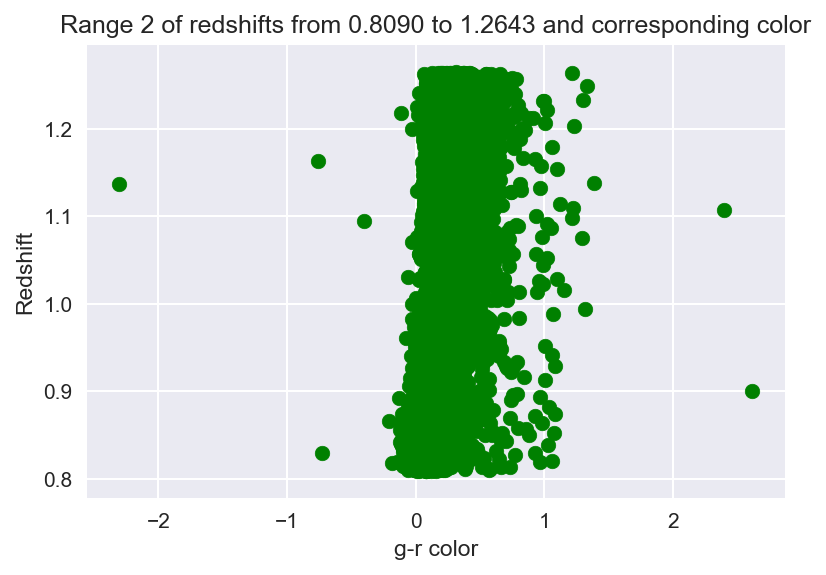

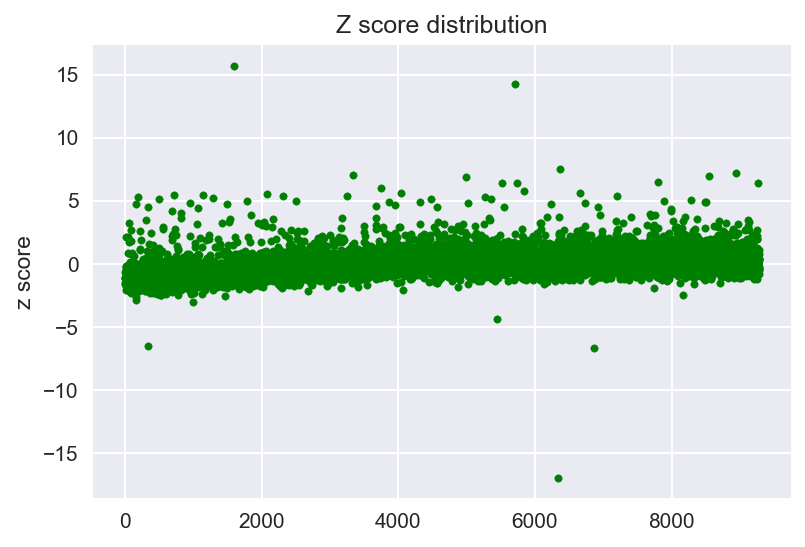

The number of outliers in the second fifth of redshifts is 100


In [171]:
# SLICE 2

gr_slice2 = slice_2[0]
red_slice2 = slice_2[1]

color = gr_slice2
red = red_slice2

range_min = np.min(red)
range_max = np.max(red)

plt.figure(dpi=150)
plt.scatter(color,red, color='green')
plt.title("Range 2 of redshifts from %.4f to %.4f and corresponding color" % (range_min, range_max))
plt.xlabel("g-r color")
plt.ylabel("Redshift")
plt.savefig('g-r range 2')
plt.show()

# get z-scores
zscores = []
for x in color:
    z = get_zscore(color, x)
    zscores.append(z)
    
# visualize zscores
plt.figure(dpi=150)
plt.scatter(np.arange(1,9285), zscores,color='green', marker='.')
plt.title("Z score distribution")
plt.ylabel("z score")
plt.savefig('g-r range 2 zscores')
plt.show()

high_zscores = []
for z  in zscores:
    if z>3:
        high_zscores.append(z)
print ("The number of outliers in the second fifth of redshifts is %.0f" % (len(high_zscores)))

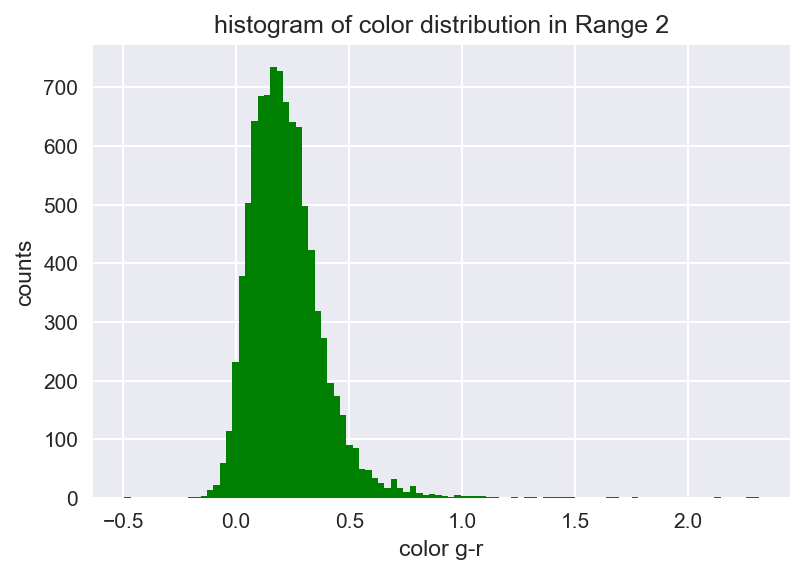

In [139]:
plt.figure(dpi=150)
plt.hist(color, bins=100, color='green')
plt.ylabel('counts')
plt.xlabel("color g-r")
plt.title('histogram of color distribution in Range 2')
plt.savefig('g-r range 2 hist')

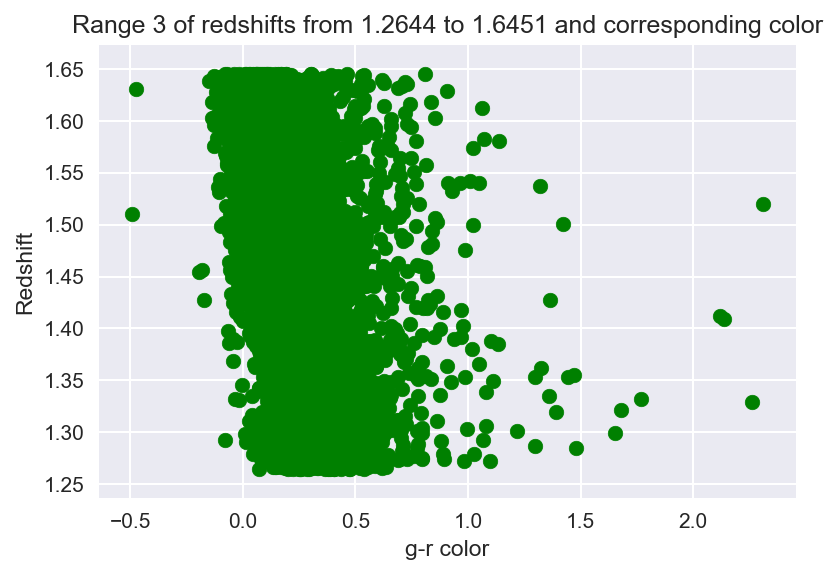

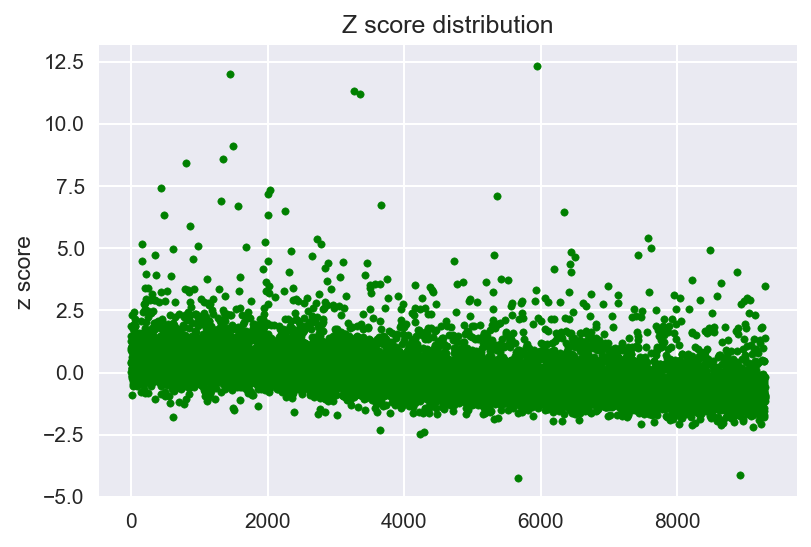

The number of outliers in the third fifth of redshifts is 112


In [137]:
# SLICE 3

gr_slice3 = slice_3[0]
red_slice3 = slice_3[1]

color = gr_slice3
red = red_slice3

range_min = np.min(red)
range_max = np.max(red)

plt.figure(dpi=150)
plt.scatter(color,red, color='green')
plt.title("Range 3 of redshifts from %.4f to %.4f and corresponding color" % (range_min, range_max))
plt.xlabel("g-r color")
plt.ylabel("Redshift")
plt.savefig('g-r range 3')
plt.show()

# get z-scores
zscores = []
for x in color:
    z = get_zscore(color, x)
    zscores.append(z)
    
# visualize zscores
plt.figure(dpi=150)
plt.scatter(np.arange(1,9285), zscores,color='green', marker='.')
plt.title("Z score distribution")
plt.ylabel("z score")
plt.savefig('g-r range 3 zscores')
plt.show()

high_zscores = []
for z  in zscores:
    if np.abs(z)>3:
        high_zscores.append(z)
print ("The number of outliers in the third fifth of redshifts is %.0f" % (len(high_zscores)))

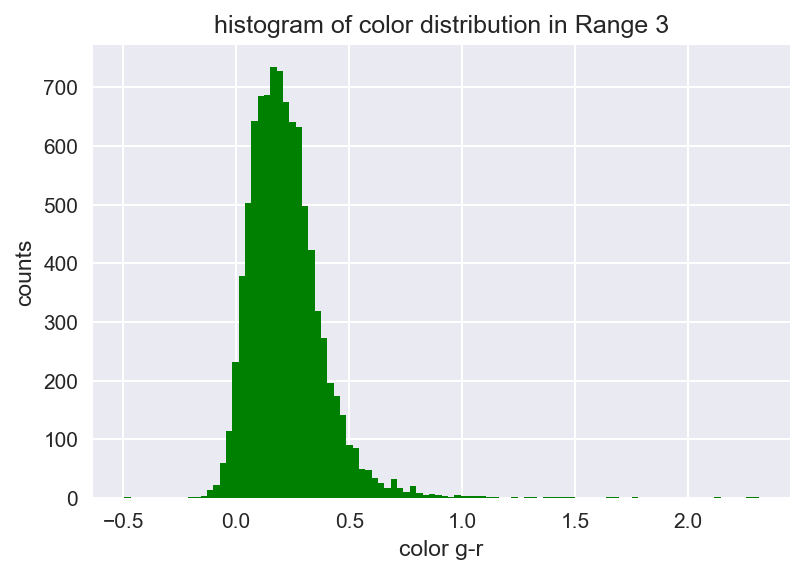

In [138]:
plt.figure(dpi=150)
plt.hist(color, bins=100, color='green')
plt.ylabel('counts')
plt.xlabel("color g-r")
plt.title('histogram of color distribution in Range 3')
plt.savefig('g-r range 3 hist')

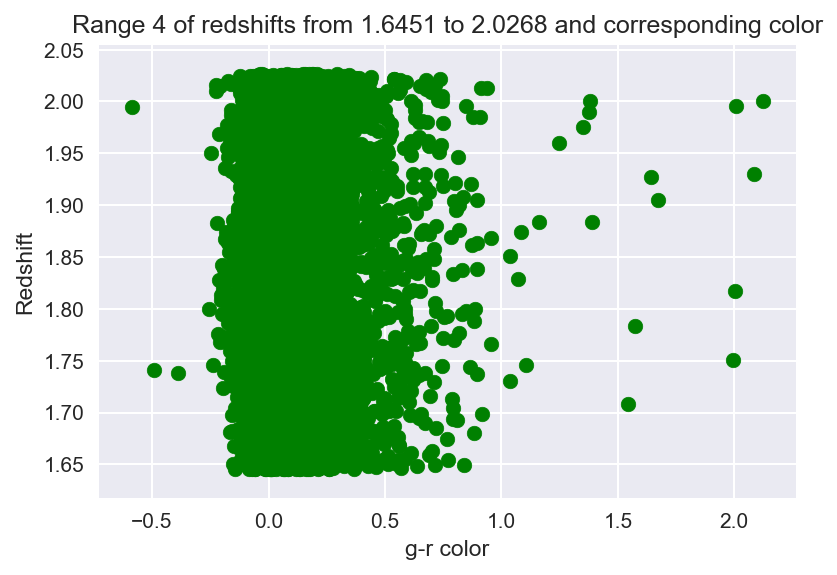

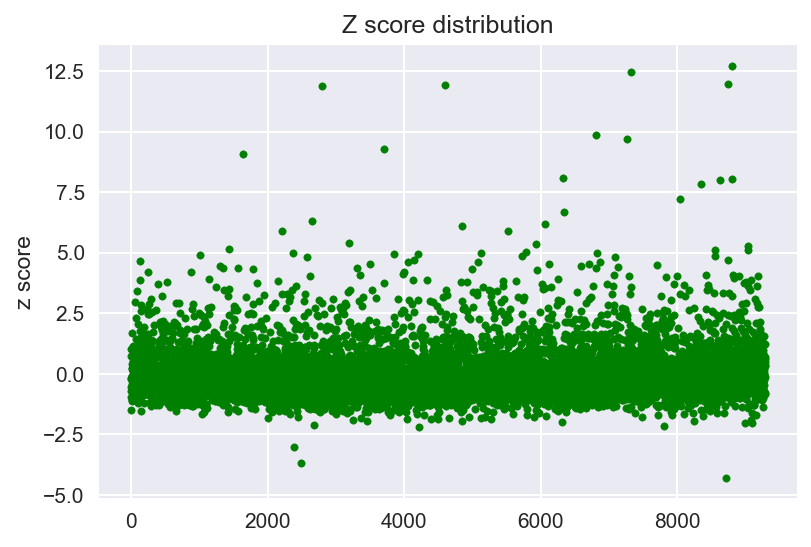

The number of outliers in the fourth fifth of redshifts is 173


In [141]:
# SLICE 4

gr_slice4 = slice_4[0]
red_slice4 = slice_4[1]

color = gr_slice4
red = red_slice4

range_min = np.min(red)
range_max = np.max(red)

plt.figure(dpi=150)
plt.scatter(color,red, color='green')
plt.title("Range 4 of redshifts from %.4f to %.4f and corresponding color" % (range_min, range_max))
plt.xlabel("g-r color")
plt.ylabel("Redshift")
plt.savefig('g-r range 4')
plt.show()

# get z-scores
zscores = []
for x in color:
    z = get_zscore(color, x)
    zscores.append(z)
    
# visualize zscores
plt.figure(dpi=150)
plt.scatter(np.arange(1,9285), zscores, color='green', marker='.')
plt.title("Z score distribution")
plt.ylabel("z score")
plt.savefig('g-r range 4 zscores')
plt.show()


high_zscores = []
for z  in zscores:
    if np.abs(z)>3:
        high_zscores.append(z)
print ("The number of outliers in the fourth fifth of redshifts is %.0f" % (len(high_zscores)))

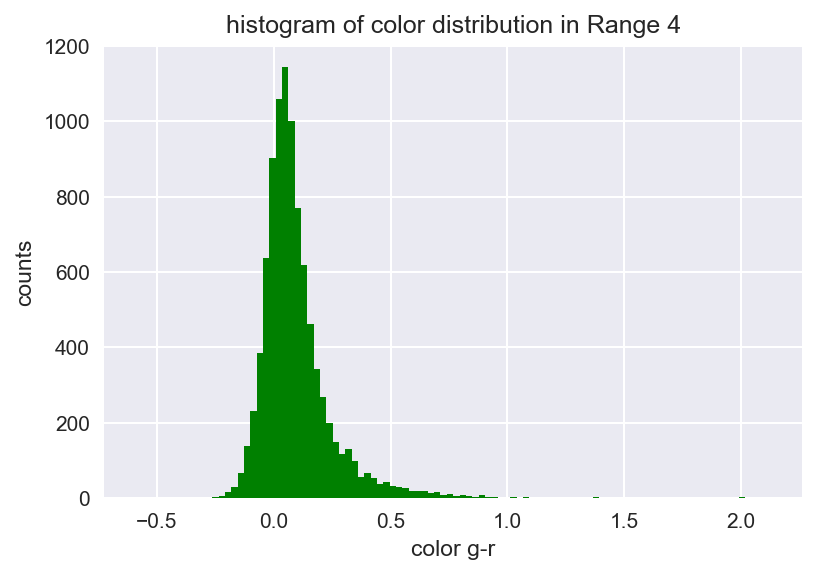

In [142]:
plt.figure(dpi=150)
plt.hist(color, bins=100, color='green')
plt.ylabel('counts')
plt.xlabel("color g-r")
plt.title('histogram of color distribution in Range 4')
plt.savefig('g-r range 4 hist')

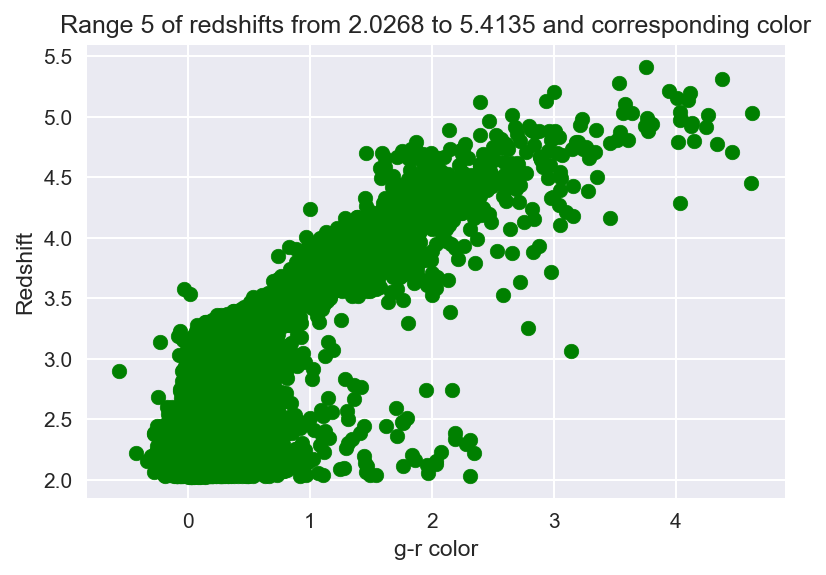

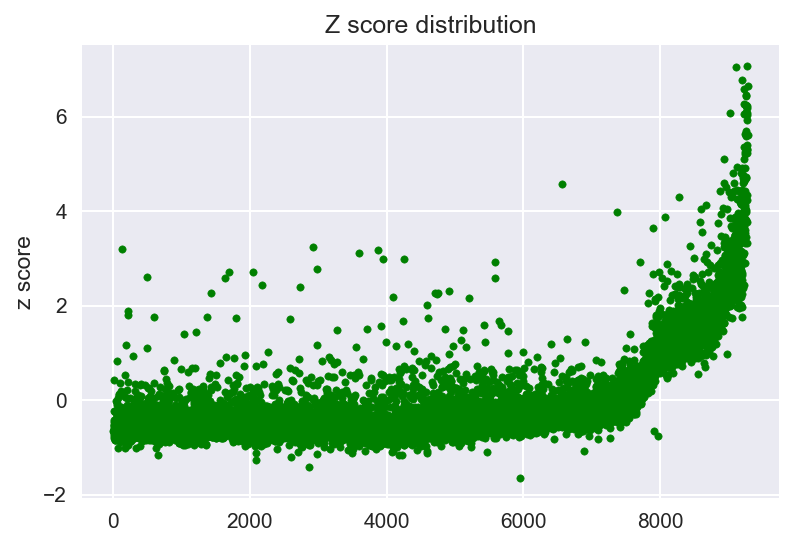

The number of outliers in the last fifth of redshifts is 203


In [143]:
# SLICE 5

gr_slice5 = slice_5[0]
red_slice5 = slice_5[1]

color = gr_slice5
red = red_slice5

range_min = np.min(red)
range_max = np.max(red)

plt.figure(dpi=150)
plt.scatter(color,red, color='green')
plt.title("Range 5 of redshifts from %.4f to %.4f and corresponding color" % (range_min, range_max))
plt.xlabel("g-r color")
plt.ylabel("Redshift")
plt.savefig('g-r range 5')
plt.show()

# get z-scores
zscores = []
for x in color:
    z = get_zscore(color, x)
    zscores.append(z)
    
# visualize zscores
plt.figure(dpi=150)
plt.scatter(np.arange(1,9285), zscores, color='green',marker='.')
plt.title("Z score distribution")
plt.ylabel("z score")
plt.savefig('g-r range 5 zscores')
plt.show()


high_zscores = []
for z  in zscores:
    if np.abs(z)>3:
        high_zscores.append(z)
print ("The number of outliers in the last fifth of redshifts is %.0f" % (len(high_zscores)))

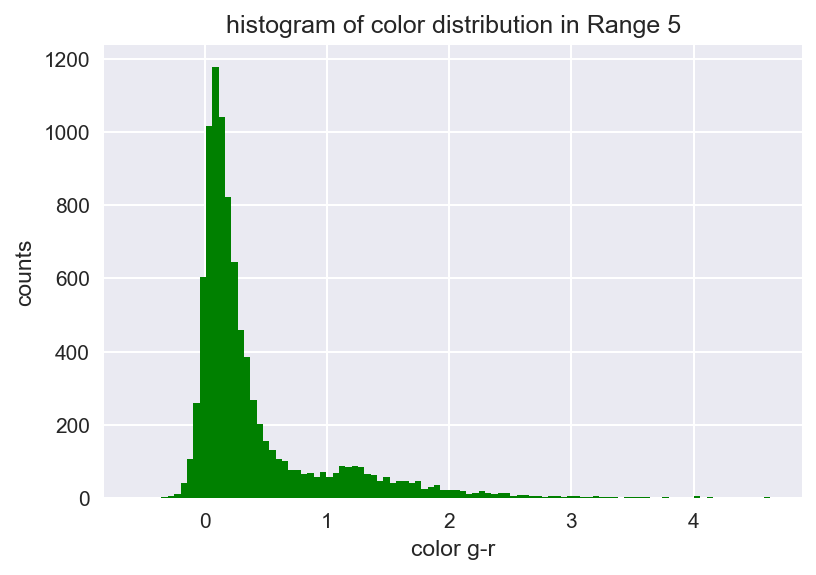

In [144]:
plt.figure(dpi=150)
plt.hist(color, bins=100, color='green')
plt.ylabel('counts')
plt.xlabel("color g-r")
plt.title('histogram of color distribution in Range 5')
plt.savefig('g-r range 5 hist')

https://www.ctspedia.org/do/view/CTSpedia/OutLier z score - empirical rule

# X-Ray Classification via Color

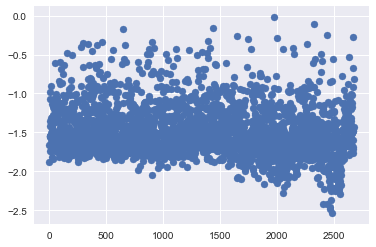

In [145]:
# some were not dected by RASS: have an xray flux value of -9
# create a mask
m = (xray > -8)

# we have 2672 with x-ray data
# make sure to keep track of indices, so we can then compare to color
mask_indices = np.where(xray > -8)

plt.scatter((np.arange(0,2672)),xray[m])

the X-ray flux was measured in count rate - the numerical values we have are log(count rate) meaning higher values do actuallu mean more "X-ray bright"

In [173]:
mean_val = np.mean(xray[m])
stddev_val = np.std(xray[m])
mean_val

-1.4891205089820359

In [147]:
ug_mask = ug[mask_indices]
gr_mask = gr[mask_indices]
ri_mask = ri[mask_indices]
iz_mask = iz[mask_indices]

In [148]:
# want bright values, but also keep track of bright value indices
bright = []
dim = []

for x  in xray[m]:
    if x >= mean_val:
        bright.append(x)
    elif mean_val >= x:
        dim.append(x)
        
index_bright = np.where(xray[m] >= mean_val)
index_dim = np.where(mean_val >=xray[m])

In [149]:
indices_br = [i for i, x in enumerate(xray[m]) if x >= mean_val]
indices_dm = [i for i, x in enumerate(xray[m]) if mean_val >= x]

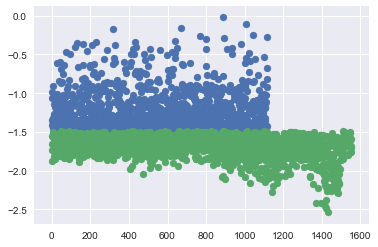

In [525]:
#visualize x-ray dim and x-ray bright
plt.scatter(np.arange(0,1119), bright)
plt.scatter(np.arange(0,1553), dim)


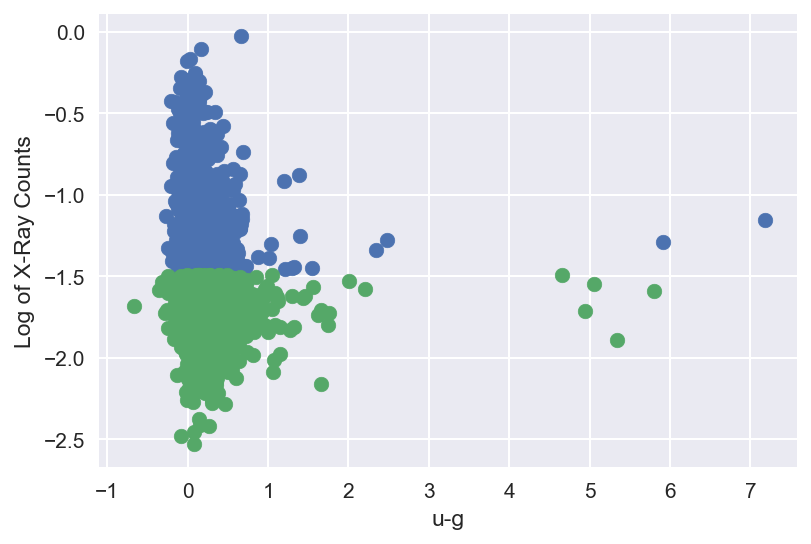

In [151]:
# lets plot bright versus color u-g
xray_mask = xray[m]

color_bright_ug = ug_mask[index_bright]
xray_bright = xray_mask[index_bright]

color_dim_ug = ug_mask[index_dim]
xray_dim = xray_mask[index_dim]

plt.figure(dpi=150)
plt.scatter(color_bright_ug, xray_bright)
plt.scatter(color_dim_ug, xray_dim)
plt.xlabel('u-g')
plt.ylabel('Log of X-Ray Counts')
plt.savefig('ug xray')

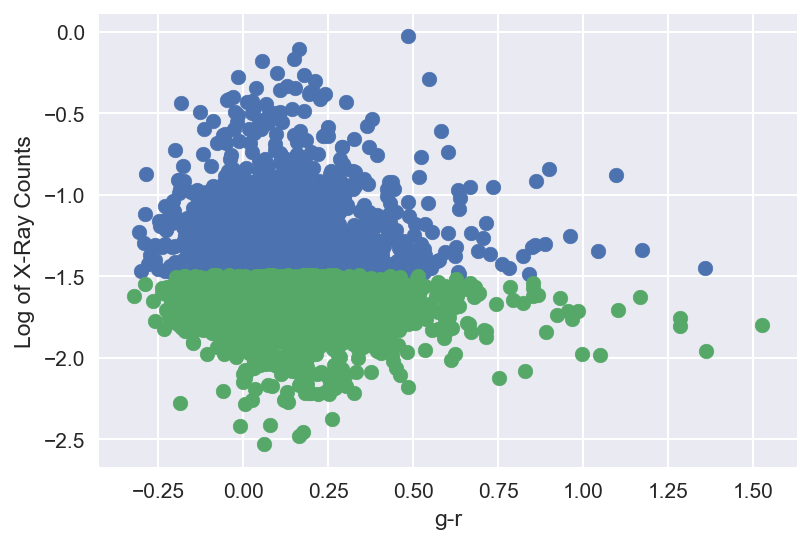

In [152]:
# lets plot bright versus color g-r
xray_mask = xray[m]

color_bright_gr = gr_mask[index_bright]
xray_bright = xray_mask[index_bright]

color_dim_gr = gr_mask[index_dim]
xray_dim = xray_mask[index_dim]

plt.figure(dpi=150)
plt.scatter(color_bright_gr, xray_bright)
plt.scatter(color_dim_gr, xray_dim)
plt.xlabel('g-r')
plt.ylabel('Log of X-Ray Counts')
plt.savefig('gr xray')

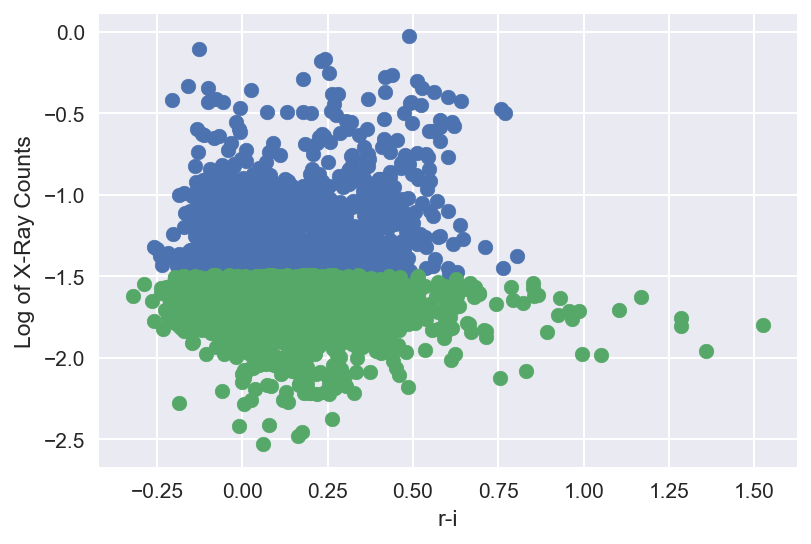

In [153]:
# lets plot bright versus color r-i
xray_mask = xray[m]

color_bright_ri = ri_mask[index_bright]
xray_bright = xray_mask[index_bright]

color_dim_ri = gr_mask[index_dim]
xray_dim = xray_mask[index_dim]

plt.figure(dpi=150)
plt.scatter(color_bright_ri, xray_bright)
plt.scatter(color_dim_ri, xray_dim)
plt.xlabel('r-i')
plt.ylabel('Log of X-Ray Counts')
plt.savefig('ri xray')

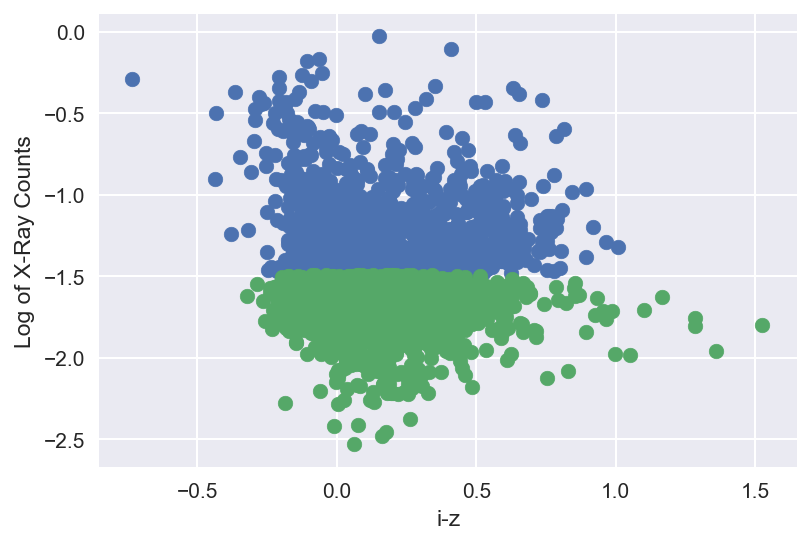

In [155]:
# lets plot bright versus color i-z
xray_mask = xray[m]

color_bright_iz = iz_mask[index_bright]
xray_bright = xray_mask[index_bright]

color_dim_iz = gr_mask[index_dim]
xray_dim = xray_mask[index_dim]

plt.figure(dpi=150)
plt.scatter(color_bright_iz, xray_bright)
plt.scatter(color_dim_iz, xray_dim)
plt.xlabel('i-z')
plt.ylabel('Log of X-Ray Counts')
plt.savefig('iz xray')

In [176]:
# lets classify

indices_br = [i for i, x in enumerate(xray[m]) if x >= mean_val]
indices_dm = [i for i, x in enumerate(xray[m]) if mean_val >= x]

colors = np.hstack((ug_mask[:,np.newaxis],gr_mask[:,np.newaxis],ri_mask[:,np.newaxis],iz_mask[:,np.newaxis]))

classes= np.zeros(2672)

for i in range(len(classes)):
    if i in indices_br:
        classes[i] = 1
        
clf = svm.LinearSVC()

clf.fit(colors, classes)

# Outputs the predicted classes from the colors
predclass = clf.predict(colors)

print("Size of data set: %d" % len(classes))
print("Matches: %d/%d" % (np.sum(predclass == classes), len(classes)))
print("Accuracy: %.2f%%" % (np.mean(predclass == classes) * 100.0))
print("Error: %d/%d" % ((len(classes)-np.sum(predclass == classes)), len(classes)))

# now cross validate
# split data
x_train, x_test, y_train, y_test = train_test_split(colors, classes, test_size=0.2)

clf.fit(x_train, y_train)
predclass_test = clf.predict(x_test)

print("---------------------")
print("Cross Validation")
print("Size of training data set: %d" % len(x_test))
print("Matches: %d/%d" % (np.sum(predclass_test == y_test), len(y_test)))
print("Accuracy: %.2f%%" % (np.mean(predclass_test == y_test) * 100.0))
print("Error: %d/%d" % ((len(y_test)-np.sum(predclass_test == y_test)), len(y_test)))

Size of data set: 2672
Matches: 1628/2672
Accuracy: 60.93%
Error: 1044/2672
---------------------
Cross Validation
Size of training data set: 535
Matches: 336/535
Accuracy: 62.80%
Error: 199/535


In [190]:
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=790)
knn.fit(colors, classes)
predclass = knn.predict(colors)

print("Size of data set: %d" % len(classes))
print("Matches: %d/%d" % (np.sum(predclass == classes), len(classes)))
print("Accuracy: %.2f%%" % (np.mean(predclass == classes) * 100.0))
print("Error: %d/%d" % ((len(classes)-np.sum(predclass == classes)), len(classes)))

#now cross validate
# split data
x_train, x_test, y_train, y_test = train_test_split(colors, classes, test_size=0.2)

knn.fit(x_train, y_train)
predclass = knn.predict(x_test)

print("---------------------")
print("Cross Validation")
print("Size of training data set: %d" % len(x_test))
print("Matches: %d/%d" % (np.sum(predclass_test == y_test), len(y_test)))
print("Accuracy: %.2f%%" % (np.mean(predclass_test == y_test) * 100.0))
print("Error: %d/%d" % ((len(y_test)-np.sum(predclass_test == y_test)), len(y_test)))

Size of data set: 2672
Matches: 1545/2672
Accuracy: 57.82%
Error: 1127/2672
---------------------
Cross Validation
Size of training data set: 535
Matches: 284/535
Accuracy: 53.08%
Error: 251/535


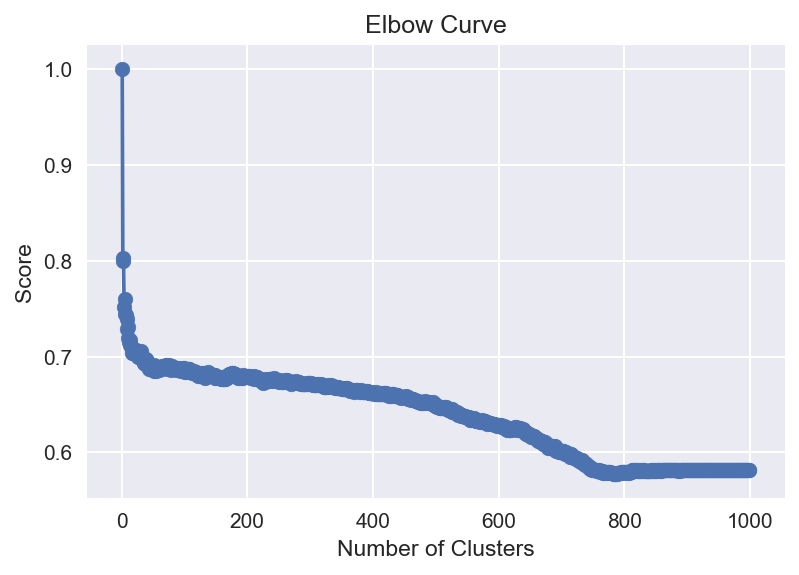

In [189]:
num_clust = range(1, 1000)
knn_test = [KNeighborsClassifier(n_neighbors=i) for i in num_clust]
score = [knn_test[i].fit(colors,classes).score(colors,classes) for i in range(len(knn_test))]

plt.figure(dpi=150)
plt.plot(num_clust,score)
plt.scatter(num_clust,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.savefig('KNN elbow curve')
plt.show()

In [188]:
plt.savefig('KNN elbow curve')


In [ ]:
9:12